<a href="https://colab.research.google.com/github/dtabuena/Data_Explore/blob/main/2023_03_30_DGC_ONLY_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openpyxl
!pip install XlsxWriter
!pip install pingouin
!pip install CMH
!pip install svgutils

from IPython.display import clear_output
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

clear_output()

from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import scipy
# from pandas.compat.numpy import np_array_datetime64_compat
from random import sample
from tqdm import tqdm
import os
import shutil
from google import colab


!wget 'https://www.dropbox.com/s/j0ts1hpt76xzvdq/arial.ttf'
mpl.font_manager.fontManager.addfont('/content/arial.ttf')

clear_output()




def restore_order(arg_ord):
    return np.argsort(arg_ord)

In [51]:

def get_files(link):
    my_drop_folder = 'my_drop_folder'
    zipped_file_path = "/content/"+my_drop_folder + ".zip"
    unzipped_file_path = "/content/"+my_drop_folder
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path
    file_list = [f for r,d,f in os.walk("/content/"+my_drop_folder )][0]
    return file_list

def read_data_file(xl_to_analyze):
    my_df_dict  = pd.read_excel('my_drop_folder/'+xl_to_analyze, engine='openpyxl',index_col=None,sheet_name=None)

    NEW_my_df_dict = {}
    for k in my_df_dict.keys():
        new_k = k
        if 'cre' in new_k:
            new_k = k.replace('Syn1-cre','/Syn1-Cre')
        NEW_my_df_dict[new_k] = my_df_dict[k]

    return NEW_my_df_dict, xl_to_analyze

def dict_to_df(my_df_dict,AP_cut=60):
    '''convert dict of categories into a DF'''
    for k in my_df_dict.keys():
        df = my_df_dict[k]
        df['type'] = k
    df_list = [my_df_dict[k] for k in my_df_dict.keys()]
    full_df = pd.concat(df_list,ignore_index=True)

    '''drop low AP amps'''
    for r in full_df.index:
        if full_df.loc[r,'AP amp'] <AP_cut:
            full_df.at[r,'AP amp'] = np.nan
    return full_df

def clean_data(labeling,full_df):

    numericals = [c for c in full_df.columns if c not in labeling ]

    full_df_norm = full_df.copy()
    mean_dict = {}
    sd_dict = {}

    if 'extras' not in full_df.columns:
        exclude_extras = False
        plot_extras = False

    for c in full_df_norm.columns:
        if c not in labeling:
            col_mean = np.mean(full_df_norm[c])
            col_sd = np.std(full_df_norm[c])
            mean_dict[c] = col_mean
            sd_dict[c] = col_sd
            full_df_norm[c] = (full_df_norm[c] - col_mean)/col_sd


    null_check = pd.isna(full_df_norm)
    incomplete =[]
    for r in full_df_norm.index:
        vals = np.array(null_check.loc[r,numericals])
        bad = any(vals)
        if bad:
            incomplete.append(r)


    complete = [c for c in  full_df_norm.index if c not in incomplete]
    full_df_no_null = full_df_norm.loc[complete].copy()


    if exclude_extras:
        is_extra = list(full_df_no_null['extra']==1)
        extra_ind = full_df_no_null.index[is_extra]
        full_df_no_null.drop( index =extra_ind, inplace=True)


    data_X = full_df_no_null[numericals].to_numpy()
    data_for_fit = data_X
    numericals = [n.replace('(1)', '') for n in numericals]
    return numericals, data_for_fit, full_df_no_null

def get_types(full_df_no_null):
    type_list = list(full_df_no_null['type'])
    uniq_types = list(set(type_list))
    young_types = [t for t in uniq_types if '-9' in t and 'Cre' not in t]
    young_types.sort()
    cre_types = [t for t in uniq_types if 'Cre' in t]
    cre_types.sort()
    old_types = [t for t in uniq_types if '-19' in t and 'Cre' not in t]
    old_types.sort()
    uniq_types = young_types + cre_types + old_types
    # print(uniq_types)
    num_t = len(uniq_types)
    type_num = [ uniq_types.index(t) for t in type_list]
    return type_num, num_t, uniq_types,type_list

def cluster_full(data_for_fit,xl_to_analyze,labels):
    random_state = 42
    if 'CA1' in xl_to_analyze:
        random_state = 47
    if 'Type I ' in xl_to_analyze:
        random_state = 43
    if 'Type II ' in xl_to_analyze:
        random_state = 42
    

    rheo_ind = [i for i in range(len(labels)) if 'Rheo' in labels[i]][0]

    # kmeans = KMeans(n_clusters=2, random_state=random_state).fit(data_for_fit)
    needs_flip = True
    while needs_flip:
        random_state+=1
        print('random_state',random_state)
        kmeans = KMeans(n_clusters=2, random_state=random_state,n_init=10).fit(data_for_fit)
        centers = kmeans.cluster_centers_.T
        needs_flip = np.diff(centers[rheo_ind])<0
        print(np.diff(centers[rheo_ind]))

    # centers = kmeans.cluster_centers_.T
    distances = kmeans.transform(data_for_fit)
    rel_centers = (centers.T - np.mean(centers.T,axis = 0)).T


    labels = kmeans.labels_ 
    rel_counts = [np.mean( l == labels ) for l in range(2)]
    new_cent_order = np.argsort(centers[:,0]).tolist()

    total_D = np.tile(np.sum(distances,axis=1),[2,1]).T
    closeness = np.log(total_D/distances)
    closeness = (closeness - np.mean(closeness,axis=0)) / (np.std(closeness,axis=0))  
    distances_norm = (distances - np.mean(distances,axis=0)) / (np.std(distances,axis=0))
    score = closeness[:,1] - closeness[:,0]

    packaged = {'features':numericals,
                'kmeans':kmeans,
                'centers':centers,
                'distances':distances,
                'rel_centers':rel_centers,
                'rel_counts':rel_counts,
                'total_D':total_D,
                'closeness':closeness,
                'distances_norm':distances_norm,
                'score':score,
                'data_for_fit':data_for_fit,
                'new_cent_order':new_cent_order
                }

    return packaged


def plot_summary(num_t,numericals,type_list,uniq_types,packaged,df_for_34_2W_anova,folder, clust_names = ['More Excitable', 'Less Excitable'],fig_opt = {'dpi': 300, 'format':'png','bbox_inches':'tight'}):
    # fig_opt = {'dpi': 300, 'format':'svg','bbox_inches':'tight'}
    # fontdict = {'family': 'arial','size':14}
    cmap = plt.cm.cool(np.linspace(0,1,2))*np.array([0.6]*3+[1])
    dark_cool = mpl.colors.ListedColormap(cmap)
    

    kmeans = packaged['kmeans']
    centers = packaged['centers']
    distances = packaged['distances']
    rel_centers = packaged['rel_centers']
    rel_counts = packaged['rel_counts']
    total_D = packaged['total_D']
    closeness = packaged['closeness']
    distances_norm = packaged['distances_norm']
    score = packaged['score']
    data_for_fit = packaged['data_for_fit']
    cell_type = packaged['cell_type']


    plt.rcParams.update({'font.size': 18, 'font.family': 'arial'})
    colors = plt.cm.viridis(np.linspace(0,1,num_t))
    alpha_1 = 1
    alpha_2 = .4
    colors = [[4/255, 51/255, 255/255, alpha_1], [4/255, 51/255, 255/255, alpha_2],
              [255/255, 38/255, 0/255, alpha_1], [255/255, 38/255, 0/255, alpha_2], 
            #   [1/255, 143/255, 0/255, alpha_1], [1/255, 143/255, 0/255, alpha_2]]
                [254/255, 224/255, 144/255, alpha_1], [254/255, 224/255, 144/255, alpha_2]]


    list_colors = [colors[i] for i in type_num ]
    color_dc={'apoE3-KI 7-9mo': colors[0],
                'apoE3-KI 17-19mo': colors[1],
                'apoE4-KI 7-9mo':colors[2],
                'apoE4-KI 17-19mo': colors[3],
                'fE4/Syn1-Cre+ 7-9mo': colors[4],
                'fE4/Syn1-Cre- 7-9mo': colors[5],}


    # color_dc={'apoE3-KI Type_I 7-9mo': colors[0][:-1]+[alpha_1],
    #           'apoE3-KI Type_II 7-9mo': colors[1][:-1]+[alpha_2],
    #           'apoE4-KI Type_I 7-9mo': colors[2][:-1]+[alpha_1],
    #           'apoE4-KI Type_II 7-9mo': colors[3][:-1]+[alpha_2],
    #           'apoE3-KI Type_I 17-19mo': colors[4][:-1]+[alpha_1],
    #           'apoE3-KI Type_II 17-19mo': colors[5][:-1]+[alpha_2],
    #           'apoE4-KI Type_I 17-19mo': colors[6][:-1]+[alpha_1],
    #           'apoE4-KI Type_II 17-19mo': colors[7][:-1]+[alpha_2],}



    '''### raw_data_map '''
    plt.rcParams.update({'font.size': 14,'font.family': 'arial'}) #14
    counts = [np.sum( [tt==t for tt in type_list]) for t in uniq_types ]
    fig_norm_vals, ax = plt.subplots(1,num_t,figsize = [16,4],gridspec_kw={'width_ratios': counts},constrained_layout=True)
    data_X_min = np.min(data_for_fit)
    data_X_max = np.max(data_for_fit)
    extrema = np.array([-1,1]) * np.max(np.abs([data_X_min,data_X_max]))
    data_X_min = extrema[0]
    data_X_max = extrema[1]

    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = colors[ti]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        c = ax[ti].pcolor(data_for_fit.T[:,is_type], vmin=data_X_min*1.2, vmax=data_X_max*1.2)
        ax[ti].set_yticks(np.arange(len(numericals))+0.5)
        if ti ==0 : ax[ti].set_yticklabels(numericals,rotation=0)
        else:  ax[ti].get_yaxis().set_visible(False)
        ax[ti].set_xlabel('Cell (#)')
        ax[ti].title.set_text(t.replace(' ','\n'))
        start = min(is_type)+3 / len(is_type)
        stop = max(is_type)-3 / len(is_type)
    fig_norm_vals.suptitle(cell_type+ ' Normalized Parameters',y=1.05, fontsize=20)
    plt.tight_layout()
    plt.colorbar(c, ax=ax[ti],label='z-scored'+'\n'+'values')
    plt.show()

    plt.rcParams.update({'font.size': 14,'font.family': 'arial'}) #14


    ################# Centers 
    new_cent_order = np.argsort(centers[:,1]).tolist()[::-1]
    # fig_clust_pie, ax = plt.subplots(1,2,figsize = [12,5], gridspec_kw={'width_ratios': [2, 1]} )
    fig_centers, ax = plt.subplots(1,1,figsize = [4.5,4])
    ax.set_prop_cycle(color=[cmap[0], cmap[1]])
    ax.plot(centers[new_cent_order,:],'-o',linewidth=3)
    ax.legend(clust_names,loc='lower center',fontsize=12,frameon=False)
    sorted_numericals = [numericals[i] for i in new_cent_order]
    ax.set_xticks(np.arange(len(numericals)))
    ax.set_xticklabels(sorted_numericals,rotation=45,ha='right', rotation_mode='anchor',fontsize=14)
    ax.set_ylabel('z-scored'+' '+'values') 
    ax.axhline(0,color='k')
    ax.title.set_text(cell_type +' '+'Cluster Centers')
    plt.tight_layout()

    ################# Split Distance heat map
    counts = [np.sum( [tt==t for tt in type_list]) for t in uniq_types ]
    print(counts)
    b_dim = 2
    # fig_distances_split, ax = plt.subplots(1,num_t,figsize = [8,3],gridspec_kw={'width_ratios': counts},constrained_layout=True) ## OG
    fig_distances_split, ax = plt.subplots(1,num_t,figsize = [16,2],gridspec_kw={'width_ratios': counts},constrained_layout=True) ## NEw
    dist_min = np.min(distances_norm)
    dist_max = np.max(distances_norm)

    extrema = np.array([-1,1]) * np.max(np.abs([dist_min,dist_max]))
    dist_min = extrema[0]
    dist_max = extrema[1]

    plt.rcParams.update({'font.size': 14,'font.family': 'arial'}) #14
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = colors[ti]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        c = ax[ti].pcolor(distances_norm.T[:,is_type], vmin=dist_min*1.2, vmax=dist_max*1.2)
        ax[ti].set_yticks(np.arange(len(clust_names))+0.5)
        clust_names_nl = [c.replace(' ',' ') for c in clust_names]
        if ti ==0 : ax[ti].set_yticklabels(clust_names_nl,rotation=0)
        else:  ax[ti].get_yaxis().set_visible(False)        
        # ax[ti].title.set_text(t.replace(' ','\n'))
        # ax[ti].title.set_fontsize(16)
        # ax[ti].title.set_rotation(60)
        ax[ti].set_xlabel('Cell (#)')    
    fig_distances_split.tight_layout()
    fig_distances_split.colorbar(c, ax=ax[ti],label='z-scored'+'\n'+'distance')
    for ti in range(num_t):
        t = uniq_types[ti]
        ax[ti].text(0.5, 1, t.replace(' ','\n'),transform=ax[ti].transAxes,ha='center',rotation=0,va='bottom',fontsize=14)
    plt.show()
    # xxxxxxx

    ############# Combined Scatter
    fig_comb_scatter, ax = plt.subplots(1,figsize = [4,4])
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = color_dc[t]
        print(t,t_colr)
        t_colr_edge = t_colr[:-1] + [alpha_1]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        ax.scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=80)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Dist. from '+clust_names[0]+' Center \n (z-scored)')
    ax.set_ylabel('Dist. from '+clust_names[1]+' Center \n (z-scored)')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='k')
    ax.text(0.98, 0.02, ''+clust_names[1],transform=ax.transAxes,ha='right',va='bottom',fontsize=12)
    ax.text(0.02, 0.98, ''+clust_names[0],transform=ax.transAxes,ha='left',va='top',fontsize=12)
    comb_xlim = ax.get_xlim()
    comb_ylim = ax.get_ylim()
    # print(comb_xlim)
    # print(comb_ylim)
    common_lim = np.array([-1,1]) * np.max(np.abs(list(comb_xlim)+list(comb_ylim)))
    common_lim= [np.min([comb_xlim[0],comb_ylim[0]]), np.max([comb_xlim[1],comb_ylim[1]]) ]
    # print(common_lim)
    ax.set_xlim(common_lim)
    ax.set_ylim(common_lim)

    #### separate Scatter #####
    b_dim = 3
    plt.rcParams.update({'font.size': 16, 'font.family': 'arial'})
    if 'CA3' in cell_type: fig_sep_scatter, axs = plt.subplots(1,num_t,figsize = [num_t*b_dim,b_dim*1.2])
    else: fig_sep_scatter, axs = plt.subplots(2,int(num_t/2),figsize = [int(num_t/2)*b_dim,b_dim*2*1.2]) #  [int(num_t/2)*b_dim,b_dim*2]
    axs = axs.T.flatten()
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = color_dc[t]
        t_colr_edge = t_colr[:-1] + [alpha_1]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        axs[ti].scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=36)
        axs[ti].plot([0, 1], [0, 1], transform=axs[ti].transAxes,color=[0,0,0,1])
        axs[ti].title.set_text(t.replace(' ','\n'))
        axs[ti].set_xlim(common_lim)
        axs[ti].set_ylim(common_lim)


        axs[ti].set_xlabel(clust_names[0]+' Dist.',fontsize=14)
        axs[ti].set_ylabel(clust_names[1]+' Dist.',fontsize=14)
        axs[ti].text(0.98, 0.02, ''+clust_names[1],transform=axs[ti].transAxes,ha='right',va='bottom',fontsize=14)
        axs[ti].text(0.02, 0.98, ''+clust_names[0],transform=axs[ti].transAxes,ha='left',va='top',fontsize=14)

    x=distances_norm[is_type,0]
    y=distances_norm[is_type,1]
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [y[i], x[i]], 'k:')

    plt.rcParams.update({'font.size': 18, 'font.family': 'arial'})
    plt.tight_layout()


    # #### separate PDFS #####
    # fig_sep_hist, axs = plt.subplots(2,int(num_t/2),figsize = [int(num_t/2)*5,5])
    # axs = axs.T.flatten()
    # for ti in range(num_t):
    #     t = uniq_types[ti]
    #     t_colr = colors[ti]
    #     t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
    #     is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]

    #     axs[ti].hist(score[is_type],14,color=t_colr,histtype='bar',density=True,range=(-3.25,3.25),edgecolor=t_colr_edge,linewidth=1)
    #     axs[ti].title.set_text(t)
    #     axs[ti].axvline(0, color='k') # vertical
    #     axs[ti].set_ylim(0,0.65)
    #     axs[ti].set_ylabel('PDF')
    #     fs = 14
    #     axs[ti].text(.95, .85, clust_names[1],transform=axs[ti].transAxes,ha='right',fontsize = fs)
    #     axs[ti].text(.05, .85, clust_names[0],transform=axs[ti].transAxes,ha='left',fontsize = fs)

    # axs[3].set_xlabel('Residuals')
    # plt.tight_layout()



    ########  ''' Violins of Residual Plots '''
    fig_violin_residuals, ax = plt.subplots(1,figsize=[3*int(num_t/2),4])
    comb_list = list(set(df_for_34_2W_anova['combination']))

    young_types = [t for t in comb_list if '-9' in t and 'Cre' not in t]
    young_types.sort()
    cre_types = [t for t in comb_list if 'Cre' in t]
    cre_types.sort()
    old_types = [t for t in comb_list if '-19' in t and 'Cre' not in t]
    old_types.sort()
    comb_list = young_types + cre_types + old_types

    sns_dict={}
    print(comb_list)
    for ti in range(len(comb_list)):
        type_i = comb_list[ti]
        match_type = df_for_34_2W_anova['combination']==type_i
        y_vals = list(np.array(df_for_34_2W_anova[match_type]['T1_Score']))
        x_vals = np.ones_like(y_vals)*ti + int(np.floor(ti/2))
        pos = list(np.ones_like(y_vals)*ti)
        t_colr = colors[ti]    
        t_colr = color_dc[type_i]
        # t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
        # sns_dict[type_i] = y_vals
        sns_dict[type_i] =y_vals

    print(sns_dict.keys())
    sns_df =  pd.DataFrame.from_dict(sns_dict, orient='index').T
    display(sns_df.head())
   
    colors_sns = [color_dc[t] for t in sns_df.columns]
    # colors_sns = [color_dc[k] for k in color_dc.keys()]
    colors_sns = [ list(np.array(c[:-1]) + (1 - np.array(c[:-1]))* (1-c[-1])) + list(c[-1:]) for c in  colors_sns]

    sns.swarmplot(ax=ax,data=sns_df,color='k', label=t,linewidths=1,edgecolors='k',size=7)
    sns.violinplot(ax=ax,data=sns_df,palette=colors_sns, 
                   scale ='area', label=t,linewidths=1,inner='quartile',edgecolors='k')
    FS = 16
    ax.text(.05, .98, clust_names[1],transform=ax.transAxes,ha='left',va='top',fontsize = FS)
    ax.text(.05, .02, clust_names[0],transform=ax.transAxes,ha='left',fontsize = FS)
    ax.set_ylabel('Residual Value')
    ax.set_ylim(-7.5,9.5)
    ax.axhline(0,color='k')
    ax_labels = sns_df.columns
    ax.set_xticks(ticks=range(len(ax_labels)))
    ax_labels_r = [c.replace(' ','\n') for c in ax_labels]
    ax_labels_r = [c.replace('\nsyn',' syn') for c in ax_labels_r]
    ax_labels_r = [c.split('\n')[0]  for c in ax_labels_r]
    ax_labels_r = [c.replace('-Cre', '\nCre') for c in ax_labels_r]
    # ax_labels_r = ['\n'+ax_labels_r[i] if i%2 == 0 else ax_labels_r[i] for i in range(len(ax_labels_r)) ]
    ax.set_xticklabels(ax_labels_r,rotation=0,ha='center', rotation_mode='anchor',fontsize=FS)
    ax.title.set_text(cell_type+' Cluster Membership')
    
    div_x = np.sum( ['7-9' in l for l in ax_labels])-0.5
    segment_x = [div_x, div_x]
    segment_y = ax.get_ylim()*np.array([1.75,1])
    print('segments',segment_x,segment_y)
    ll = plt.plot(segment_x,segment_y,':k') # returns a sequence of line objects
    ll[0].set_clip_on(False)
    plt.text(div_x/2-0.25, segment_y[0]-0, '7-9mo', fontsize=FS+2,ha='center',va='bottom')
    plt.text(div_x+1, segment_y[0]-0, '17-19mo', fontsize=FS+2,ha='center',va='bottom')

    plt.show()

    fig_norm_vals.savefig(f'{folder}/Normalized_Vals_split.'+fig_opt['format'],**fig_opt)
    fig_violin_residuals.savefig(f'{folder}/fig_violin_residuals.'+fig_opt['format'],**fig_opt)    
    fig_distances_split.savefig(f'{folder}/fig_distances_split.'+fig_opt['format'],**fig_opt)    
    # fig_centers.savefig(f'{folder}/centers.'+fig_opt['format'],**fig_opt)
    # fig_pie.savefig(f'{folder}/pie.'+fig_opt['format'],**fig_opt)
    fig_sep_scatter.savefig(f'{folder}/GenoType_dist_Separate.'+fig_opt['format'],**fig_opt)
    fig_comb_scatter.savefig(f'{folder}/GenoType_dist.'+fig_opt['format'],**fig_opt)
    # fig_sep_hist.savefig(f'{folder}/GenoType_Histos.'+fig_opt['format'],**fig_opt)
    return None    


def do_stats(type_list,score):
    is_E3 = ['E3' in t for t in type_list ]
    is_9mo = ['-19' not in t for t in type_list ]
    age_list = ['7-9' if b else '17-19' for b in is_9mo]
    genotype = ['apoE3-KI' if b else 'apoE4-KI' for b in is_E3]
    is_crePos = ['cre+' in t for t in type_list ]
    is_creNeg = ['cre-' in t for t in type_list ]
    not_cree = [not any( [is_crePos[i], is_creNeg[i]] ) for i in range(len(is_crePos))]
    e34_genotype = [genotype[i] for i in range(len(not_cree)) if not_cree[i]]
    e34_score = [score[i] for i in range(len(not_cree)) if not_cree[i]]
    e34_age = [str(age_list[i])+'mo' for i in range(len(not_cree)) if not_cree[i]]
    genotype_list_str = [t.replace(' 7-9mo', '').replace(' 17-19mo', '') for t in type_list]
    age_list_str = [str(a)+'mo' for a in age_list]
    
    df_for_34_2W_anova =  pd.DataFrame({'genotype': genotype_list_str,  'Age': age_list_str,'T1_Score': score})


    ANOVA2_results = pg.anova(dv='T1_Score', between=['genotype', 'Age'], data=df_for_34_2W_anova, detailed=True)
    display(ANOVA2_results)

    ANOVA2_results.to_csv(f'{folder}/2W_results Age-Geno.csv')
    df_for_34_2W_anova['combination'] = df_for_34_2W_anova.genotype + " " + df_for_34_2W_anova.Age
    m_comp = pairwise_tukeyhsd(endog=df_for_34_2W_anova['T1_Score'], groups=df_for_34_2W_anova['combination'], alpha=0.05)
    tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
    tukey_data = tukey_data.sort_values('p-adj',ascending=True)
    display(tukey_data)

    tukey_data.to_csv(f'{folder}/pairwise Age-Genotype.csv')
    df_for_34_2W_anova.to_csv(f'{folder}/Scores.csv')
    return df_for_34_2W_anova, tukey_data




def cross_val(data_for_fit,numericals,new_cent_order,folder,k=2,
              num_iter = 1000,SubSampleFrac = .8,cell_type='',fig_opt = {'dpi': 300, 'format':'svg','bbox_inches':'tight'},ds_iter=10):
    
    cval_res = {}
    
    center_list = []
    label_list = []
    sub_sample_ind_list = []
    full_label_list = []
    pred_all = True
    if not new_cent_order: new_cent_order = np.arange(len(numericals))        
    sorted_numericals = [numericals[i] for i in new_cent_order]
    plt.rcParams.update({'font.size': 18, 'font.family': 'arial'})
    cmap = plt.cm.cool(np.linspace(0,1,k))*np.array([0.6]*3+[1])
    dark_cool = mpl.colors.ListedColormap(cmap)

    for ni in tqdm( range(num_iter) ):
        sub_sample_ind = []
        for t in uniq_types:
            t_inds = [i for i in range(len(type_list)) if t in type_list[i]]
            # print(t_inds)
            sub_sample_ind.extend( sample(t_inds, int(len(t_inds)*SubSampleFrac) ) )
        kmeans_iter = KMeans(n_clusters=k, random_state=42,n_init=10).fit(data_for_fit[sub_sample_ind][:,new_cent_order])
        centers_iter = kmeans_iter.cluster_centers_.T
        centers_iter = centers_iter - np.mean(centers_iter,axis=0)
        labels_iter = kmeans_iter.labels_
        if pred_all:
            labels_iter = kmeans_iter.predict(data_for_fit)

        if ni>0:
            corco = np.corrcoef(centers_iter.T,center_list[0].T)
            corco = corco[0:k,k:]
            ind = np.argmax(corco,axis=0) 
            centers_iter = centers_iter[:,ind]
            labels_iter = [ind[l] for l in labels_iter]
        
        if not pred_all:
            full_label_iter = np.empty((data_for_fit.shape[0],))
            full_label_iter[:] = np.nan
            full_label_iter[sub_sample_ind] = labels_iter
        else:
            full_label_iter = labels_iter

        center_list.append(centers_iter)
        label_list.append(labels_iter)
        sub_sample_ind_list.append(sub_sample_ind_list)
        full_label_list.append(full_label_iter)
   
    center_stack = np.stack(center_list)
    mean_center = np.mean(center_stack,0)
    nintey_p_center = np.percentile(center_stack, [.5, 99.5], axis=0)

    cval_res['mean_center'] = mean_center
    cval_res['confidence'] = nintey_p_center

    ####### PLOT CENTERS
    plt.rcParams.update({'font.size': 18,'font.family': 'arial'}) #14
    fig_cv_cent, ax = plt.subplots(1,figsize = (9,5))
    handle_list = []
    if k == 2:
        clust_names = [ 'More Excitable', 'Less Excitable'] 
        rheo_index_in_center = [i for i in range(len(numericals)) if 'Rheo' in numericals[i]]
        rheo_dif = np.diff(mean_center[rheo_index_in_center,:])[0]
        if rheo_dif<0: clust_names=clust_names[::-1]

    for ki in range(k):
        if k==2: ax.plot(mean_center[:,ki].T,'-o',color=cmap[ki],linewidth=3,label = clust_names[ki])
        else: ax.plot(mean_center[:,ki].T,'-o',color=cmap[ki],linewidth=3)
        ax.plot(nintey_p_center[0,:,ki].T,':',color=cmap[ki],linewidth=2)
        ax.plot(nintey_p_center[1,:,ki].T,':',color=cmap[ki],linewidth=2)

    ax.set_xticks(np.arange(len(numericals)))
    ax.set_xticklabels(sorted_numericals,rotation=45,ha='right', rotation_mode='anchor') # ,fontsize=14
    ax.axhline(0, color='k')   
        
    if k == 2: ax.legend(loc='lower center',fontsize=14,frameon=False)
    ax.set_ylabel('z-scored'+' '+'values') 


    full_label_stack = np.stack(full_label_list)

    pseudo_truth = scipy.stats.mode(full_label_stack,axis=0, nan_policy='omit')[0]
    is_match = (full_label_stack == pseudo_truth)*1. # convert to float so can accept nans
    is_match[np.isnan(full_label_stack)]=np.nan
    consistency_iter = np.nanmean(is_match, axis = 1)
    mean_consistency_iter = np.nanmean(consistency_iter)
    std_consistency_iter = np.nanstd(consistency_iter)
    consistency_cell = np.nanmean(is_match, axis = 0)
    mean_consistency_cell = np.nanmean(consistency_cell)
    sd_consistency_cell = np.nanstd(consistency_cell)
    consistency_report = 'label consistency: ' + str(round(mean_consistency_cell*100,1)) + '% +- ' + str(round(sd_consistency_cell*100,2)) + ' (chance: ' + str(round(1/k*100,1))+')'
    ax.title.set_text(cell_type)


    cval_res['mean_consistency_iter'] = mean_consistency_iter
    cval_res['std_consistency_iter'] = std_consistency_iter
    cval_res['consistency_cell'] = consistency_cell
    cval_res['mean_consistency_cell'] = mean_consistency_cell

    plt.tight_layout()
    plt.show()
    fig_cv_cent.savefig(f'{folder}/CrossVal_Data k={k} Centers.'+fig_opt['format'],**fig_opt)

    plt.rcParams.update({'font.size': 18, 'font.family': 'arial'})
    fig_cv_prob, ax = plt.subplots(2,2,figsize=[6,4.5], gridspec_kw={'height_ratios': [3, 1],'width_ratios': [4, 1.1]}  )
    ax  = ax.T.flatten()

    iters_ds = np.arange(0,num_iter,ds_iter) +1
    cell_ids = np.arange(0,full_label_stack.shape[0]) +1
    pcol = ax[0].pcolorfast(iters_ds,cell_ids,full_label_stack[::ds_iter,:],cmap=dark_cool)
    # pcol.set_edgecolor('face')

    ax[0].set_xlabel('Cell (#)')
    ax[0].set_ylabel('Iteration (#)')
    ax[0].xaxis.set_label_position('top') 
    ax[0].xaxis.tick_top()

    ax[1].scatter(np.arange(len(consistency_cell)),consistency_cell*100,color='k',s=2)
    ax[1].axhline(1/k*100,color='k',linestyle=':')
    ax[1].set_ylabel('Cell\nConsistency (%)')
    ax[1].set_ylim((0,102))
    ax[1].set_xlim((0,is_match.shape[1]))
    ax[1].set_xlabel('Cell (#)')

    ax[2].scatter(consistency_iter*100,np.arange(num_iter),color='k',s=2)
    ax[2].axvline(1/k*100,color='k',linestyle=':')
    ax[2].set_xlabel('Iteration\nConsistency (%)')
    ax[2].set_xlim((102,0))
    ax[2].set_ylim((0,num_iter))
    ax[2].yaxis.tick_right()
    ax[2].xaxis.set_label_position('top') 
    ax[2].xaxis.tick_top()

    # fig.delaxes(ax[3])
    ax[3].errorbar(mean_consistency_iter*100, mean_consistency_cell*100,
                   yerr=sd_consistency_cell*100, xerr=std_consistency_iter*100,color='k',capsize=3)
    ax[3].axvline(1/k*100,color='k',linestyle=':')
    ax[3].axhline(1/k*100,color='k',linestyle=':')
    ax[3].set_xlim((100,0))
    ax[3].set_ylim((0,100))
    ax[3].yaxis.tick_right()

    fig_cv_prob.suptitle(f'k = {k} clusters', y=1.15,fontsize=22,)#  y=1.075
    plt.show()

    fig_cv_prob.savefig(f'{folder}/CrossVal_Data k={k} Labeling.'+fig_opt['format'],**fig_opt)

    

    return cval_res


def save_dl(folder):
    root_list = []
    f_list = []
 
    fold_name = folder
    fold_name = fold_name.replace(' ','_')
    zip_name= fold_name+'.zip'

    print(folder)
    !zip -r $zip_name $folder
    colab.files.download(zip_name)
    return None








In [8]:
link = 'https://www.dropbox.com/sh/vnndh8qo9dkhyh3/AABc-bU5bXepR5PmBcQMvwrba?dl=0' # NEW sAHP
# link = 'https://www.dropbox.com/sh/e52vk7qbr4p0pfw/AACSiEAskL4ZSexlFN0L5S76a?dl=0' # OLD sAHP
file_list = get_files(link)
file_list = [f for f in file_list if 'param' in f]
_ = [print(f) for f in file_list]
file_list_DG = [f for f in file_list if 'DG' in f]
file_list = file_list_DG

Archive:  /content/my_drop_folder.zip
mapname:  conversion of  failed
replace /content/my_drop_folder/CA1 main parameters_Clean.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/my_drop_folder/CA1 main parameters_Clean.xlsx  
 extracting: /content/my_drop_folder/CA3 parameters for PCA_Clean.xlsx  
 extracting: /content/my_drop_folder/DG Type I GC main parameters_Clean.xlsx  
 extracting: /content/my_drop_folder/DG Type II GC main parameters_Clean.xlsx  
DG Type II GC main parameters_Clean.xlsx
DG Type I GC main parameters_Clean.xlsx
CA1 main parameters_Clean.xlsx
CA3 parameters for PCA_Clean.xlsx


In [ ]:
multipack={}

fig_opt = {'dpi': 100, 'format':'svg','bbox_inches':'tight'}

for f in file_list: # [f for f in file_list if 'CA3' in f]
    my_df_dict, xl_to_analyze = read_data_file(f)
    folder = xl_to_analyze.split('.')[0].replace(' ','_')
    try: os.makedirs(folder)
    except: None
    full_df = dict_to_df(my_df_dict,AP_cut=60)
    labeling = ['cell','Cell','type','extra']
    numericals, data_for_fit, full_df_no_null = clean_data(labeling, full_df)
    type_num, num_t, uniq_types,type_list = get_types(full_df_no_null)
    packaged = cluster_full(data_for_fit,xl_to_analyze,numericals)
    if 'CA1' in f: packaged['cell_type'] ='CA1 PC'
    if 'CA3' in f: packaged['cell_type'] ='CA3 PC'
    if 'II' in f: packaged['cell_type'] ='DG GC II'
    if ' I ' in f: packaged['cell_type'] ='DG GC I'   
    df_for_34_2W_anova, tukey_data = do_stats(type_list,packaged['score'])
    plot_summary(num_t,numericals,type_list,uniq_types,packaged,df_for_34_2W_anova,folder,fig_opt =fig_opt)
    k2_cval = cross_val(data_for_fit,numericals,packaged['new_cent_order'],folder,k=2,num_iter = 1000,SubSampleFrac = .8,
              cell_type=packaged['cell_type'],fig_opt =fig_opt,ds_iter=5)
    k3_cval = cross_val(data_for_fit,numericals,packaged['new_cent_order'],folder,k=3,num_iter = 1000,SubSampleFrac = .8,
              cell_type=packaged['cell_type'],fig_opt =fig_opt,ds_iter=5)
    packaged['k2_cval'] = k2_cval
    packaged['k3_cval'] = k3_cval
    multipack[packaged['cell_type']] = packaged
    save_dl(folder)

In [ ]:
# https://www.tutorialspoint.com/how-to-make-a-polygon-radar-spider-chart-in-python-matplotlib
features =  np.array(multipack['DG GC II']['features'])
feat_ord = ['Cm', 'Rin', 'RMP',  'AP threshold', 'fAHP', 'sAHP', 'AP width', 'AP amp', 'AP rise time', 'Adaptation Ratio', 'Rheobase', 'Spike Latency','I-F Gain', 'Max Firing rate']
f_order = [np.where(features==fi)[0][0] for fi in feat_ord]


alt_comb_centers, ax = plt.subplots(1,1,figsize=(16,8),subplot_kw={'projection': 'polar'})
rad_feats = np.append(features[f_order],features[f_order[0]])
theta = (np.arange(len(features) + 1) / float(len(features))) * 2 * np.pi  
# theta = theta + np.pi/2
ax.set_theta_zero_location("N")
rad_feats=[f.replace(' ','\n') for f in rad_feats]
ax.set_xticks(theta[:-1],rad_feats[:-1],fontsize = 20,)
tiks = [-1,-0.5,0,0.5,1]
# ax.set_yticks(tiks,[f'r = {t}' for t in tiks])
ax.set_ylim(bottom=-2, top=1)
ax.set_rlabel_position(180)
full_x = np.append(np.arange(0,360,10)/360*np.pi*2,0)

full_y_zero = np.zeros_like(full_x)
ax.plot(full_x,full_y_zero,':k',linewidth=2)
ax.tick_params(pad=40)

ci_types = [list(multipack.keys())[ci]   for ci in range(num_types)]
centers = [multipack[ci_type]['centers'] for ci_type in ci_types]
center_conc = np.concatenate(centers,axis=-1)
center_mins = np.min(center_conc,axis=1)

print(rad_feats)
for ci in range(num_types):
    ci_type = list(multipack.keys())[ci]    
    centers = multipack[ci_type]['centers']

    radii_m = np.append(centers[f_order,0],centers[f_order[0],0])
    radii_l = np.append(centers[f_order,1],centers[f_order[0],1])

    'Relative'
    # c_min = np.append(center_mins[f_order],center_mins[f_order[0]])
    # radii_m = radii_m-c_min
    # radii_l = radii_l-c_min
    # print(np.array([centers[f_order[0],:]]))
    # print(centers[f_order,:])
    # print(np.append(centers[f_order,:],np.array([centers[f_order[0],:]]), axis=0))
    # c_min = np.min(np.append(centers[f_order,:],np.array([centers[f_order[0],:]]), axis=0) ,axis=1)
    # radii_m = radii_m-c_min
    # radii_l = radii_l-c_min

   

    ax.set_yticks([-1,-0.5,0,0.5,1])
    ax.set_ylim(bottom=-2, top=1)

    m_label = ci_type + ' - More Excit.'
    l_label = ci_type + ' - Less Excit.'

    m_color = cmap[0,:]*[1,1,1,(ci+1)/4]
    l_color = cmap[1,:]*[1,1,1,(ci+1)/4]
    d_theta = theta[1]*0.8

    # 'Spider'
    # ax.plot(theta[:],radii_m[:],label=m_label,color=m_color,linewidth=3,marker='.',markersize=10)
    # ax.plot(theta[:],radii_l[:],label=l_label,color=l_color,linewidth=3,marker='.',markersize=10)

    # 'Steps'
    # ax.step(theta[:]-theta[1]/2,radii_m[:],label=m_label,color=m_color,linewidth=3)
    # ax.step(theta[:]-theta[1]/2,radii_l[:],label=l_label,color=l_color,linewidth=3)

    'Bars'
    ax.bar(theta[:]+d_theta/1*(ci/num_types)-d_theta/2/num_types*(num_types-1),radii_m[:],label=m_label,color=m_color,width=d_theta/num_types/1)# 
    ax.bar(theta[:]+d_theta/1*(ci/num_types)-d_theta/2/num_types*(num_types-1),radii_l[:],label=m_label,color=l_color,width=d_theta/num_types/1)#

ax.legend([handles[i] for i in order],[bar_labels[i] for i in order],ncol=2,fontsize = 20,loc='lower center',frameon=False,bbox_to_anchor=(0.5, -0.5)) ## ,bbox_to_anchor=(1, 0), loc='upper center'
d_theta = 2*np.pi/14


fontsize=16
ax.text( d_theta*(1.5-0.5), -1.1, 'Membrane\nProperties', va='center',ha='center',fontsize=fontsize)
ax.text( d_theta*(6-0.5), -1.1, 'AP\nWaveform', va='center',ha='center',fontsize=fontsize)
ax.text( d_theta*(11.5-0.5), -1.1, 'Active\nProperties', va='center',ha='center',fontsize=fontsize)

ax.bar( d_theta*(1.5-0.5), 3, width = d_theta*3,color=[1*.80]*3,zorder=-4,bottom=-2,edgecolor='k')
ax.bar( d_theta*(6-0.5), 3, width = d_theta*6,color=[1*.90]*3,zorder=-4,bottom=-2,edgecolor='k')
ax.bar( d_theta*(11.5-0.5), 3, width = d_theta*5,color=[1*1]*3,zorder=-4,bottom=-2,edgecolor='k')
ax.set_yticks(tiks,[f'r = {t}' for t in tiks],rotation=45)
plt.show()
alt_comb_centers.savefig('alt_comb_centers.'+fig_opt['format'],**fig_opt)
colab.files.download('alt_comb_centers.'+fig_opt['format'])

In [ ]:
## Alt Center

In [21]:

from cmh import CMH

print(type_list)



##### DG TypeR ######
type_list =['DG Type II', 'DG Type I']
cmh_df = pd.DataFrame(columns=['Geno','Age','Type'])
counts = {}

e4_table =pd.DataFrame(columns=type_list,index=['7-9mo','17-19mo'])
e3_table = e4_table.copy()
for f in file_list:
    if 'DG' in f:
        c_type = [t for t in type_list if t+' ' in f][0]
        my_df_dict,_ = read_data_file(f)
        for k,v in my_df_dict.items():
            if '19' in k: age = '17-19mo'
            else: age = '7-9mo'
            if 'E4' in k: e4_table.at[age,c_type]=v.shape[0]
            else: e3_table.at[age,c_type]=v.shape[0]

            a = np.array([[k.split(' ')[0], k.split(' ')[1], c_type]]*v.shape[0])
            df2 = pd.DataFrame(data=a, columns=['Geno','Age','Type'])
            cmh_df = cmh_df.append(df2, ignore_index=True)

print('E3')
display(e3_table)

print('E4')
display(e4_table)

result = CMH(cmh_df, 'Type', 'Age', stratifier='Geno')
display(result)

['apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE4-KI T

<ipython-input-21-86e65fd9069a>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-21-86e65fd9069a>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-21-86e65fd9069a>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-21-86e65fd9069a>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cmh_df = cmh_df.append(df2, ignore_index=True)
<ipython-input-21-86e65fd9069a>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

,DG Type II,DG Type I
7-9mo,23,11
17-19mo,28,29


E4


,DG Type II,DG Type I
7-9mo,22,12
17-19mo,26,36


Cochran-Mantel-Haenszel Chi2 test

"Type" x "Age", stratified by "Geno"

Cochran-Mantel-Haenszel M^2 = 7.37318, dof = 1, p-value = 0.0066

In [186]:
def plot_summary_DG_comb(num_t,numericals,type_list,uniq_types,packaged,df_for_34_2W_anova,folder, clust_names = ['More Excitable', 'Less Excitable'],fig_opt = {'dpi': 300, 'format':'png','bbox_inches':'tight'}):
    # fig_opt = {'dpi': 300, 'format':'svg','bbox_inches':'tight'}
    # fontdict = {'family': 'arial','size':14}
    cmap = plt.cm.cool(np.linspace(0,1,2))*np.array([0.6]*3+[1])
    dark_cool = mpl.colors.ListedColormap(cmap)
    

    kmeans = packaged['kmeans']
    centers = packaged['centers']
    distances = packaged['distances']
    rel_centers = packaged['rel_centers']
    rel_counts = packaged['rel_counts']
    total_D = packaged['total_D']
    closeness = packaged['closeness']
    distances_norm = packaged['distances_norm']
    score = packaged['score']
    data_for_fit = packaged['data_for_fit']
    cell_type = packaged['cell_type']


    plt.rcParams.update({'font.size': 18, 'font.family': 'arial'})
    colors = plt.cm.viridis(np.linspace(0,1,num_t))
    alpha_1 = 0.8
    alpha_2 = 0.2
    colors = [[4/255, 51/255, 255/255, alpha_1], [4/255, 51/255, 255/255, alpha_2],
              [255/255, 38/255, 0/255, alpha_1], [255/255, 38/255, 0/255, alpha_2],
              [0, 0.75, 0.75, alpha_1], [0, 0.75, 0.75, alpha_2],
              [1, 0, 0.65, alpha_1], [1, 0, 0.65, alpha_2],
              ]

    list_colors = [colors[i] for i in type_num ]
    color_dc={'apoE3-KI Type_I 7-9mo': colors[0],#[:-1]+[alpha_1],
              'apoE3-KI Type_II 7-9mo': colors[4],#[:-1]+[alpha_1],
              'apoE4-KI Type_I 7-9mo': colors[1],#[:-1]+[alpha_2],
              'apoE4-KI Type_II 7-9mo': colors[5],#[:-1]+[alpha_2],
              'apoE3-KI Type_I 17-19mo': colors[2],#[:-1]+[alpha_1],
              'apoE3-KI Type_II 17-19mo': colors[6],#[:-1]+[alpha_1],
              'apoE4-KI Type_I 17-19mo': colors[3],#[:-1]+[alpha_2],
              'apoE4-KI Type_II 17-19mo': colors[7],#[:-1]+[alpha_2],
              }
              


    '''
    apoE3-KI Type_I 7-9mo
    apoE3-KI Type_II 7-9mo
    apoE4-KI Type_I 7-9mo
    apoE4-KI Type_II 7-9mo
    apoE3-KI Type_I 17-19mo
    apoE3-KI Type_II 17-19mo
    apoE4-KI Type_I 17-19mo
    apoE4-KI Type_II 17-19mo
    '''

    '''raw_data_map '''
    plt.rcParams.update({'font.size': 14,'font.family': 'arial'}) #14
    counts = [np.sum( [tt==t for tt in type_list]) for t in uniq_types ]

    plot_ratios = counts
    plot_ratios[-1] =int(plot_ratios[-1]) + int(np.sum(plot_ratios)/8*0.6)

    fig_norm_vals, ax = plt.subplots(1,num_t,figsize = [16,4],gridspec_kw={'width_ratios': counts},constrained_layout=True)
    data_X_min = np.min(data_for_fit)
    data_X_max = np.max(data_for_fit)
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = colors[ti]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        c = ax[ti].pcolor(data_for_fit.T[:,is_type], vmin=data_X_min*1.2, vmax=data_X_max*1.2)
        ax[ti].set_yticks(np.arange(len(numericals))+0.5)
        if ti ==0 : ax[ti].set_yticklabels(numericals,rotation=0)
        else:  ax[ti].get_yaxis().set_visible(False)
        ax[ti].set_xlabel('Cell (#)')
        ax[ti].title.set_text(t.replace(' ','\n'))
        start = min(is_type)+3 / len(is_type)
        stop = max(is_type)-3 / len(is_type)
    fig_norm_vals.suptitle(cell_type+ ' Normalized Parameters',y=1.05, fontsize=20)
    plt.tight_layout()
    plt.colorbar(c, ax=ax[ti],label='z-scored'+'\n'+'values')
    plt.show()

    plt.rcParams.update({'font.size': 14,'font.family': 'arial'}) #14


    ################# Centers 
    new_cent_order = np.argsort(centers[:,1]).tolist()[::-1]
    # fig_clust_pie, ax = plt.subplots(1,2,figsize = [12,5], gridspec_kw={'width_ratios': [2, 1]} )
    fig_centers, ax = plt.subplots(1,1,figsize = [4.5,4])
    ax.set_prop_cycle(color=[cmap[0], cmap[1]])
    ax.plot(centers[new_cent_order,:],'-o',linewidth=3)
    ax.legend(clust_names,loc='lower center',fontsize=12,frameon=False)
    sorted_numericals = [numericals[i] for i in new_cent_order]
    ax.set_xticks(np.arange(len(numericals)))
    ax.set_xticklabels(sorted_numericals,rotation=45,ha='right', rotation_mode='anchor',fontsize=14)
    ax.set_ylabel('z-scored'+' '+'values') 
    ax.axhline(0,color='k')
    ax.title.set_text(cell_type +' '+'Cluster Centers')
    plt.tight_layout()

    ################# Split Distance heat map
    counts = [np.sum( [tt==t for tt in type_list]) for t in uniq_types ]
    print(counts)
    b_dim = 2
    # fig_distances_split, ax = plt.subplots(1,num_t,figsize = [8,3],gridspec_kw={'width_ratios': counts},constrained_layout=True) ## OG
    fig_distances_split, ax = plt.subplots(1,num_t,figsize = [16,2],gridspec_kw={'width_ratios': counts},constrained_layout=True) ## NEw
    dist_min = np.min(distances_norm)
    dist_max = np.max(distances_norm)
    plt.rcParams.update({'font.size': 14,'font.family': 'arial'}) #14
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = colors[ti]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        c = ax[ti].pcolor(distances_norm.T[:,is_type], vmin=dist_min*1.2, vmax=dist_max*1.2)
        ax[ti].set_yticks(np.arange(len(clust_names))+0.5)
        clust_names_nl = [c.replace(' ',' ') for c in clust_names]
        if ti ==0 : ax[ti].set_yticklabels(clust_names_nl,rotation=0)
        else:  ax[ti].get_yaxis().set_visible(False)        
        # ax[ti].title.set_text(t.replace(' ','\n'))
        # ax[ti].title.set_fontsize(16)
        # ax[ti].title.set_rotation(60)
        ax[ti].set_xlabel('Cell (#)')    
    fig_distances_split.tight_layout()
    fig_distances_split.colorbar(c, ax=ax[ti],label='z-scored'+'\n'+'distance')
    for ti in range(num_t):
        t = uniq_types[ti]
        ax[ti].text(0.5, 1, t.replace(' ','\n'),transform=ax[ti].transAxes,ha='center',rotation=0,va='bottom',fontsize=14)
    plt.show()
    # xxxxxxx

    ############# Combined Scatter
    fig_comb_scatter, ax = plt.subplots(1,figsize = [4,4])
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = color_dc[t]
        print(t,t_colr)
        t_colr_edge = t_colr[:-1] + [alpha_1]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        ax.scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=80)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Dist. from '+clust_names[0]+' Center \n (z-scored)')
    ax.set_ylabel('Dist. from '+clust_names[1]+' Center \n (z-scored)')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='k')
    ax.text(0.98, 0.02, ''+clust_names[1],transform=ax.transAxes,ha='right',va='bottom',fontsize=12)
    ax.text(0.02, 0.98, ''+clust_names[0],transform=ax.transAxes,ha='left',va='top',fontsize=12)
    comb_xlim = ax.get_xlim()
    comb_ylim = ax.get_ylim()
    # print(comb_xlim)
    # print(comb_ylim)
    common_lim = np.array([-1,1]) * np.max(np.abs(list(comb_xlim)+list(comb_ylim)))
    common_lim= [np.min([comb_xlim[0],comb_ylim[0]]), np.max([comb_xlim[1],comb_ylim[1]]) ]
    # print(common_lim)
    ax.set_xlim(common_lim)
    ax.set_ylim(common_lim)

    #### separate Scatter #####
    b_dim = 3
    plt.rcParams.update({'font.size': 16, 'font.family': 'arial'})
    if 'CA3' in cell_type: fig_sep_scatter, axs = plt.subplots(1,num_t,figsize = [num_t*b_dim,b_dim*1.2])
    else: fig_sep_scatter, axs = plt.subplots(2,int(num_t/2),figsize = [int(num_t/2)*b_dim,b_dim*2*1.2]) #  [int(num_t/2)*b_dim,b_dim*2]
    axs = axs.T.flatten()
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = color_dc[t]
        t_colr_edge = t_colr[:-1] + [alpha_1]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        axs[ti].scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=36)
        axs[ti].plot([0, 1], [0, 1], transform=axs[ti].transAxes,color=[0,0,0,1])
        axs[ti].title.set_text(t.replace(' ','\n'))
        axs[ti].set_xlim(common_lim)
        axs[ti].set_ylim(common_lim)


        axs[ti].set_xlabel(clust_names[0]+' Dist.',fontsize=14)
        axs[ti].set_ylabel(clust_names[1]+' Dist.',fontsize=14)
        axs[ti].text(0.98, 0.02, ''+clust_names[1],transform=axs[ti].transAxes,ha='right',va='bottom',fontsize=14)
        axs[ti].text(0.02, 0.98, ''+clust_names[0],transform=axs[ti].transAxes,ha='left',va='top',fontsize=14)

    x=distances_norm[is_type,0]
    y=distances_norm[is_type,1]
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [y[i], x[i]], 'k:')

    plt.rcParams.update({'font.size': 18, 'font.family': 'arial'})
    plt.tight_layout()


    ########  ''' Violins of Residual Plots '''
    fig_violin_residuals, ax = plt.subplots(1,figsize=[3*int(num_t/2),4])
    comb_list = list(set(df_for_34_2W_anova['combination']))

    young_types = [t for t in comb_list if '-9' in t and 'Cre' not in t]
    young_types.sort()
    cre_types = [t for t in comb_list if 'Cre' in t]
    cre_types.sort()
    old_types = [t for t in comb_list if '-19' in t and 'Cre' not in t]
    old_types.sort()
    comb_list = young_types + cre_types + old_types

    sns_dict={}
    print('comb_list',comb_list)
    for ti in range(len(comb_list)):
        type_i = comb_list[ti]
        match_type = df_for_34_2W_anova['combination']==type_i
        y_vals = list(np.array(df_for_34_2W_anova[match_type]['T1_Score']))
        x_vals = np.ones_like(y_vals)*ti + int(np.floor(ti/2))
        pos = list(np.ones_like(y_vals)*ti)
        t_colr = colors[ti]    
        t_colr = color_dc[type_i]
        sns_dict[type_i] =y_vals

    print(sns_dict.keys())
    sns_df =  pd.DataFrame.from_dict(sns_dict, orient='index').T
    display(sns_df.head())
   
    colors_sns = [color_dc[t] for t in sns_df.columns]
    colors_sns = [ list(np.array(c[:-1]) + (1 - np.array(c[:-1]))* (1-c[-1])) + list(c[-1:]) for c in  colors_sns]

    sns.swarmplot(ax=ax,data=sns_df,color='k', label=t,linewidths=1,edgecolors='k',size=7)
    sns.violinplot(ax=ax,data=sns_df,palette=colors_sns, 
                   scale ='area', label=t,linewidths=1,inner='quartile',edgecolors='k')
    FS = 16
    ax.text(.05, .98, clust_names[1],transform=ax.transAxes,ha='left',va='top',fontsize = FS)
    ax.text(.05, .02, clust_names[0],transform=ax.transAxes,ha='left',fontsize = FS)
    ax.set_ylabel('Residual Value')
    ax.set_ylim(-7.5,9.5)
    ax.axhline(0,color='k')
    ax_labels = sns_df.columns
    ax.set_xticks(ticks=range(len(ax_labels)))
    ax_labels_r = [c.replace(' ','\n') for c in ax_labels]
    ax_labels_r = [c.replace('\nsyn',' syn') for c in ax_labels_r]
    ax_labels_r = [c.replace('7-9mo','') for c in ax_labels_r]
    ax_labels_r = [c.replace('17-19mo','') for c in ax_labels_r]
    ax_labels_r = [c.replace('-Cre', '\nCre') for c in ax_labels_r]
    print('ax_labels',ax_labels)
    print('ax_labels_r',ax_labels_r)
    ax.set_xticklabels(ax_labels_r,rotation=0,ha='center', rotation_mode='anchor',fontsize=FS)
    ax.title.set_text(cell_type+' Cluster Membership')
    
    div_x = np.sum( ['7-9' in l for l in ax_labels])-0.5
    segment_x = [div_x, div_x]
    segment_y = ax.get_ylim()*np.array([1.75,1])
    print('segments',segment_x,segment_y)
    ll = plt.plot(segment_x,segment_y,':k') # returns a sequence of line objects
    ll[0].set_clip_on(False)
    plt.text(div_x/2-0.25, segment_y[0]-0, '7-9mo', fontsize=FS+2,ha='center',va='bottom')
    plt.text(div_x+div_x/2+0.25, segment_y[0]-0, '17-19mo', fontsize=FS+2,ha='center',va='bottom')

    plt.show()

    fig_norm_vals.savefig(f'{folder}/Normalized_Vals_split.'+fig_opt['format'],**fig_opt)
    fig_violin_residuals.savefig(f'{folder}/fig_violin_residuals.'+fig_opt['format'],**fig_opt)    
    fig_distances_split.savefig(f'{folder}/fig_distances_split.'+fig_opt['format'],**fig_opt)    
    fig_sep_scatter.savefig(f'{folder}/GenoType_dist_Separate.'+fig_opt['format'],**fig_opt)
    fig_comb_scatter.savefig(f'{folder}/GenoType_dist.'+fig_opt['format'],**fig_opt)
    return None

['DG Type II GC main parameters_Clean.xlsx', 'DG Type I GC main parameters_Clean.xlsx']


<ipython-input-186-f4ec9952d95e>:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


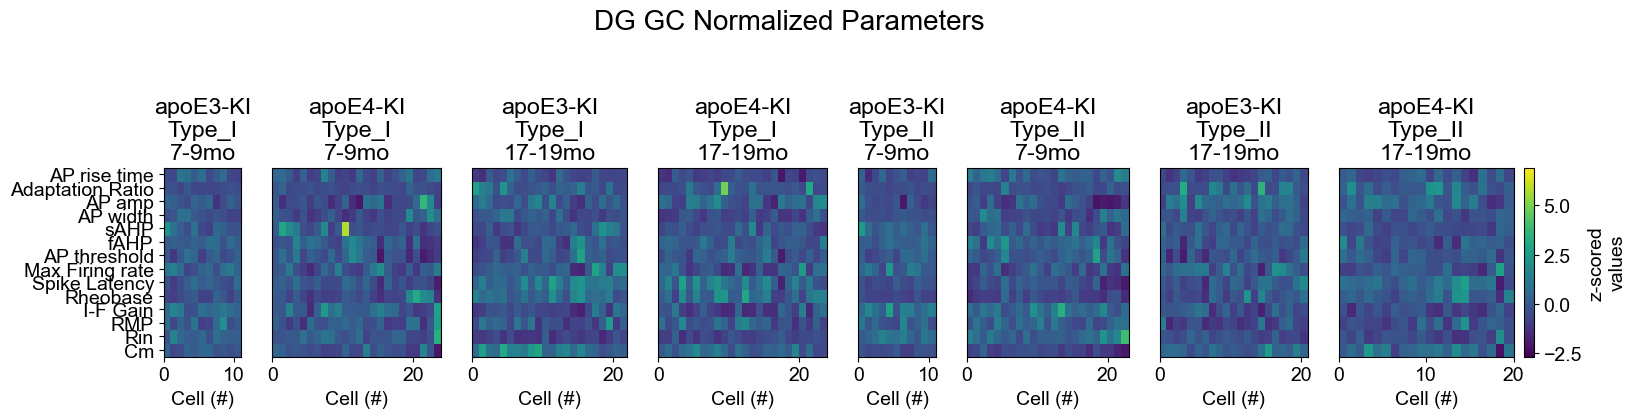

[11, 24, 22, 24, 11, 23, 21, 20]


<ipython-input-186-f4ec9952d95e>:122: UserWarning: The figure layout has changed to tight
  fig_distances_split.tight_layout()


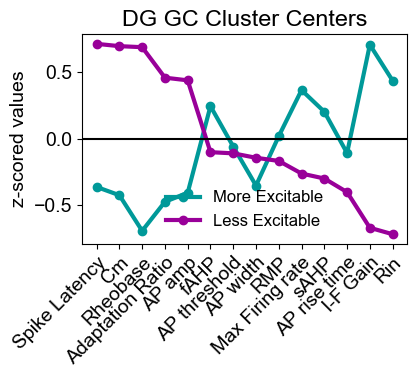

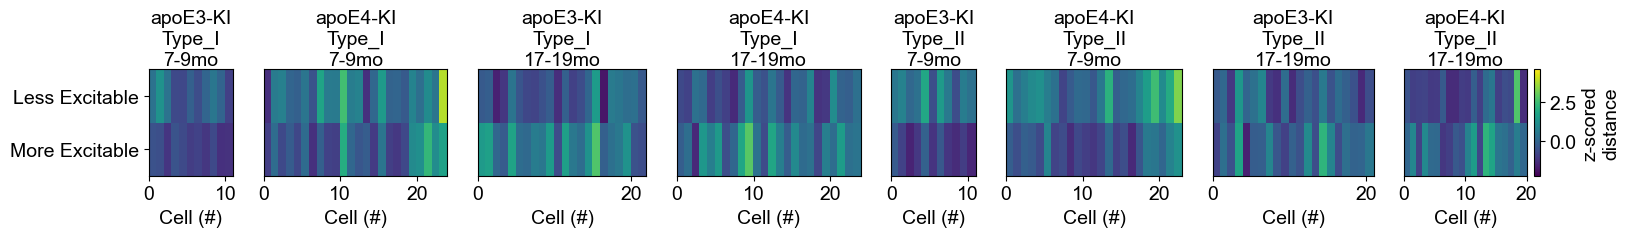

apoE3-KI Type_I 7-9mo [0.01568627450980392, 0.2, 1.0, 0.8]
apoE4-KI Type_I 7-9mo [0.01568627450980392, 0.2, 1.0, 0.2]
apoE3-KI Type_I 17-19mo [1.0, 0.14901960784313725, 0.0, 0.8]
apoE4-KI Type_I 17-19mo [1.0, 0.14901960784313725, 0.0, 0.2]
apoE3-KI Type_II 7-9mo [0, 0.75, 0.75, 0.8]
apoE4-KI Type_II 7-9mo [0, 0.75, 0.75, 0.2]
apoE3-KI Type_II 17-19mo [1, 0, 0.65, 0.8]
apoE4-KI Type_II 17-19mo [1, 0, 0.65, 0.2]
comb_list ['apoE3-KI Type_I 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE4-KI Type_I 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE3-KI Type_I 17-19mo', 'apoE3-KI Type_II 17-19mo', 'apoE4-KI Type_I 17-19mo', 'apoE4-KI Type_II 17-19mo']
dict_keys(['apoE3-KI Type_I 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE4-KI Type_I 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE3-KI Type_I 17-19mo', 'apoE3-KI Type_II 17-19mo', 'apoE4-KI Type_I 17-19mo', 'apoE4-KI Type_II 17-19mo'])


,apoE3-KI Type_I 7-9mo,apoE3-KI Type_II 7-9mo,apoE4-KI Type_I 7-9mo,apoE4-KI Type_II 7-9mo,apoE3-KI Type_I 17-19mo,apoE3-KI Type_II 17-19mo,apoE4-KI Type_I 17-19mo,apoE4-KI Type_II 17-19mo
0,-1.327949,2.521022,-1.052563,-1.238048,0.580388,0.913411,-1.902070,0.860170
1,-2.557239,2.515453,-2.714478,0.382821,-0.456936,1.985017,-1.487491,3.118914
2,-3.082198,3.631705,-4.127696,1.186613,-2.287455,-3.912014,-1.092335,-0.214415
3,0.381663,1.689773,-2.824141,0.637813,-0.371427,1.764983,-1.725393,2.947353
4,-0.007590,1.734729,-2.255677,-4.245634,-1.243182,2.816561,-2.728893,2.256240


/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


ax_labels Index(['apoE3-KI Type_I 7-9mo', 'apoE3-KI Type_II 7-9mo',
       'apoE4-KI Type_I 7-9mo', 'apoE4-KI Type_II 7-9mo',
       'apoE3-KI Type_I 17-19mo', 'apoE3-KI Type_II 17-19mo',
       'apoE4-KI Type_I 17-19mo', 'apoE4-KI Type_II 17-19mo'],
      dtype='object')
ax_labels_r ['apoE3-KI\nType_I\n', 'apoE3-KI\nType_II\n', 'apoE4-KI\nType_I\n', 'apoE4-KI\nType_II\n', 'apoE3-KI\nType_I\n', 'apoE3-KI\nType_II\n', 'apoE4-KI\nType_I\n', 'apoE4-KI\nType_II\n']
segments [3.5, 3.5] [-13.125   9.5  ]


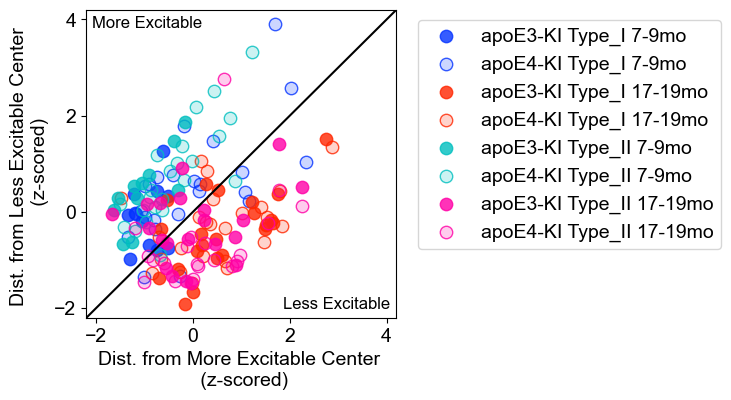

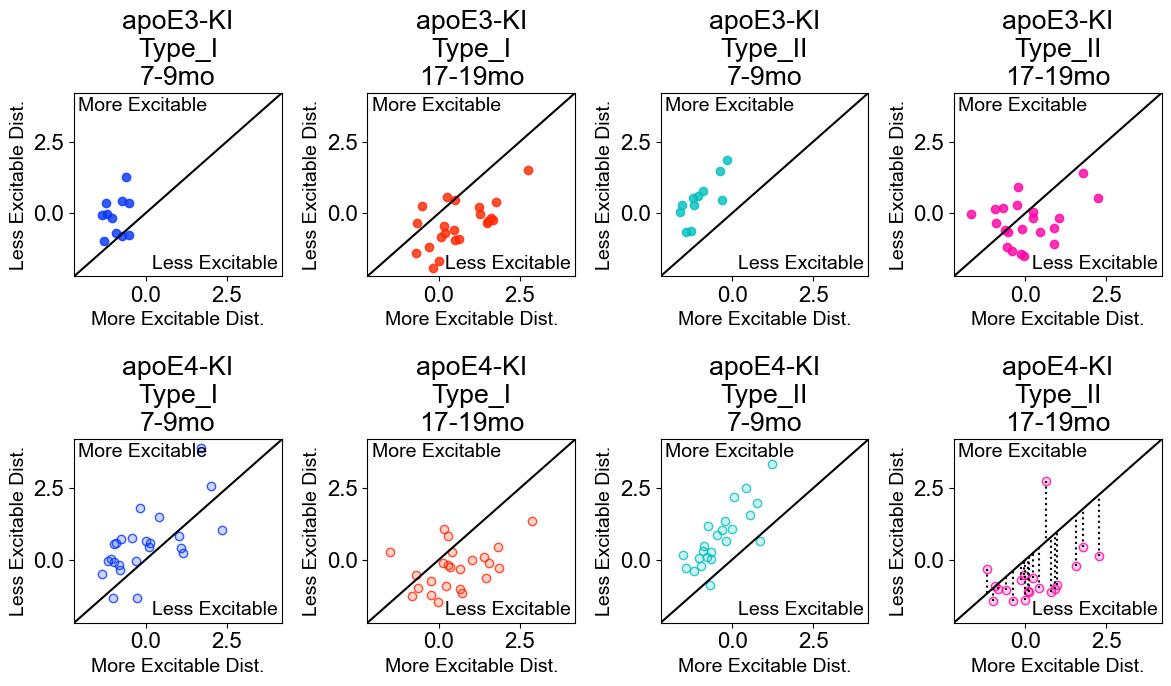

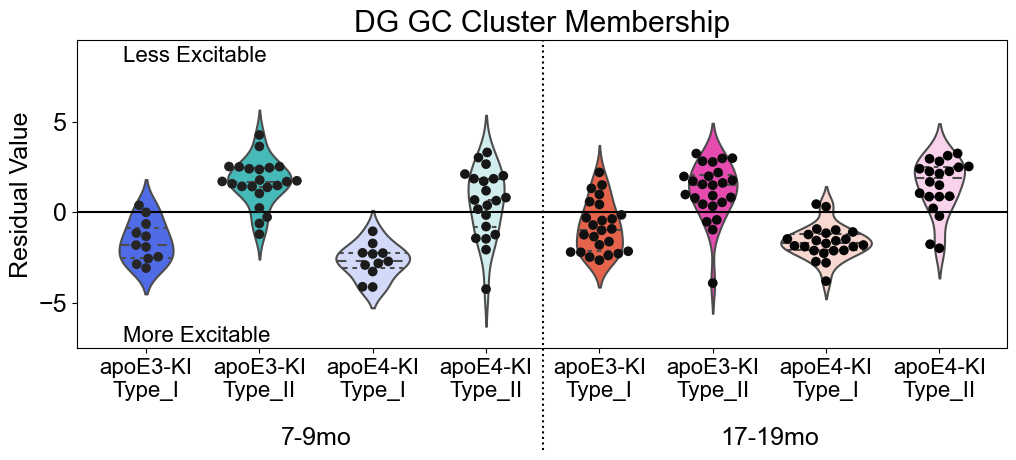

100%|██████████| 1000/1000 [00:18<00:00, 55.30it/s]
<ipython-input-51-32e329e998a7>:552: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pseudo_truth = scipy.stats.mode(full_label_stack,axis=0, nan_policy='omit')[0]


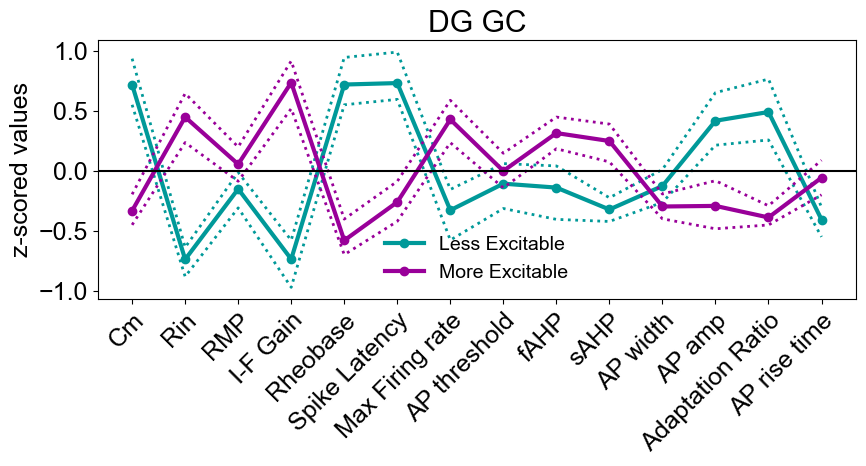

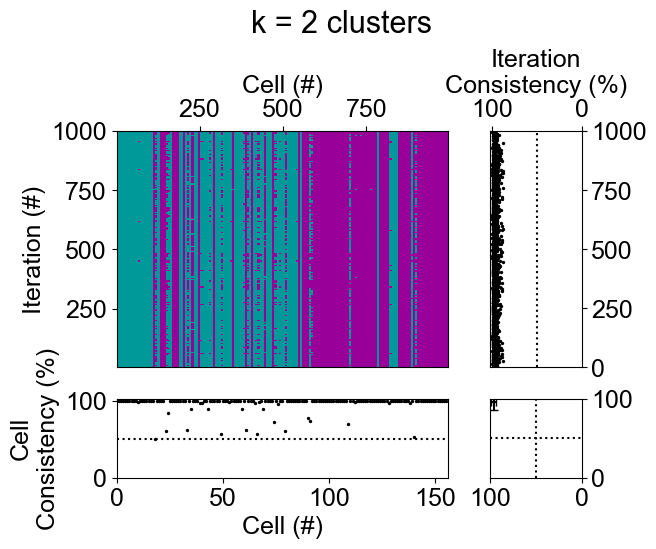

random_state 43
[1.37388013]


,Source,SS,DF,MS,F,p-unc,np2
0,genotype,31.194254,3.0,10.398085,5.283606,1.726298e-03,0.096739
1,Age,288.567674,1.0,288.567674,146.630660,6.879014e-24,0.497676
2,genotype * Age,11.735890,3.0,3.911963,1.987796,1.183142e-01,0.038733
3,Residual,291.262520,148.0,1.967990,NaN,NaN,NaN


,group1,group2,meandiff,p-adj,lower,upper,reject
0,apoE3-KI Type_I 17-19mo,apoE3-KI Type_I 7-9mo,-3.2216,0.0000,-4.8144,-1.6287,True
25,apoE4-KI Type_I 7-9mo,apoE4-KI Type_II 17-19mo,2.2642,0.0000,0.9582,3.5701,True
24,apoE4-KI Type_I 17-19mo,apoE4-KI Type_II 7-9mo,-2.8149,0.0000,-4.0735,-1.5562,True
20,apoE3-KI Type_II 7-9mo,apoE4-KI Type_II 17-19mo,4.1470,0.0000,2.5278,5.7662,True
18,apoE3-KI Type_II 7-9mo,apoE4-KI Type_I 17-19mo,3.8544,0.0000,2.2838,5.4250,True
17,apoE3-KI Type_II 17-19mo,apoE4-KI Type_II 7-9mo,-2.1676,0.0000,-3.4695,-0.8657,True
11,apoE3-KI Type_I 7-9mo,apoE4-KI Type_II 17-19mo,3.0471,0.0000,1.4279,4.6663,True
9,apoE3-KI Type_I 7-9mo,apoE4-KI Type_I 17-19mo,2.7545,0.0000,1.1840,4.3251,True
13,apoE3-KI Type_II 17-19mo,apoE3-KI Type_II 7-9mo,-3.2071,0.0000,-4.8126,-1.6017,True
4,apoE3-KI Type_I 17-19mo,apoE4-KI Type_I 7-9mo,-2.4386,0.0000,-3.7118,-1.1654,True


apoE3-KI Type_I 7-9mo
apoE4-KI Type_I 7-9mo
apoE3-KI Type_I 17-19mo
apoE4-KI Type_I 17-19mo
apoE3-KI Type_II 7-9mo
apoE4-KI Type_II 7-9mo
apoE3-KI Type_II 17-19mo
apoE4-KI Type_II 17-19mo


<ipython-input-186-f4ec9952d95e>:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


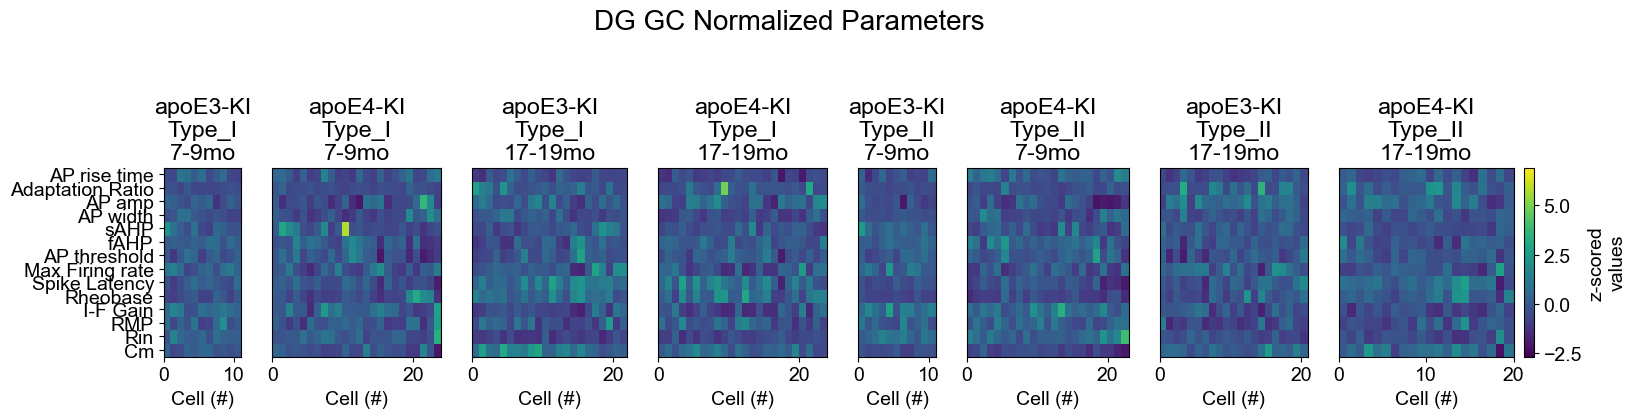

[11, 24, 22, 24, 11, 23, 21, 20]


<ipython-input-186-f4ec9952d95e>:122: UserWarning: The figure layout has changed to tight
  fig_distances_split.tight_layout()


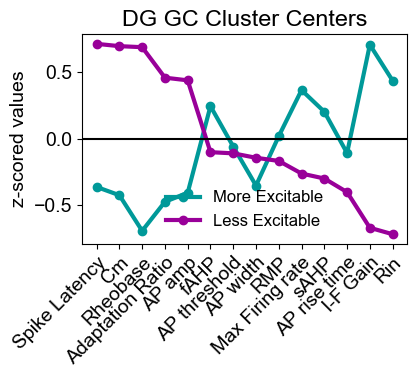

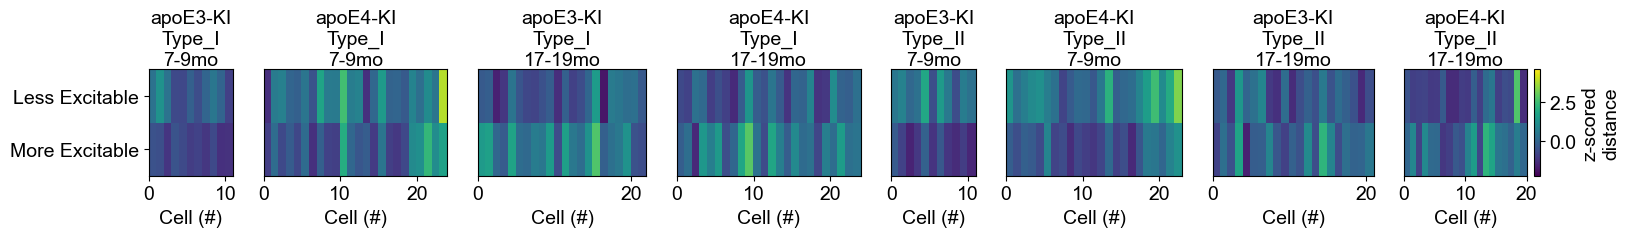

apoE3-KI Type_I 7-9mo [0.01568627450980392, 0.2, 1.0, 0.8]
apoE4-KI Type_I 7-9mo [0.01568627450980392, 0.2, 1.0, 0.2]
apoE3-KI Type_I 17-19mo [1.0, 0.14901960784313725, 0.0, 0.8]
apoE4-KI Type_I 17-19mo [1.0, 0.14901960784313725, 0.0, 0.2]
apoE3-KI Type_II 7-9mo [0, 0.75, 0.75, 0.8]
apoE4-KI Type_II 7-9mo [0, 0.75, 0.75, 0.2]
apoE3-KI Type_II 17-19mo [1, 0, 0.65, 0.8]
apoE4-KI Type_II 17-19mo [1, 0, 0.65, 0.2]
comb_list ['apoE3-KI Type_I 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE4-KI Type_I 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE3-KI Type_I 17-19mo', 'apoE3-KI Type_II 17-19mo', 'apoE4-KI Type_I 17-19mo', 'apoE4-KI Type_II 17-19mo']
dict_keys(['apoE3-KI Type_I 7-9mo', 'apoE3-KI Type_II 7-9mo', 'apoE4-KI Type_I 7-9mo', 'apoE4-KI Type_II 7-9mo', 'apoE3-KI Type_I 17-19mo', 'apoE3-KI Type_II 17-19mo', 'apoE4-KI Type_I 17-19mo', 'apoE4-KI Type_II 17-19mo'])


,apoE3-KI Type_I 7-9mo,apoE3-KI Type_II 7-9mo,apoE4-KI Type_I 7-9mo,apoE4-KI Type_II 7-9mo,apoE3-KI Type_I 17-19mo,apoE3-KI Type_II 17-19mo,apoE4-KI Type_I 17-19mo,apoE4-KI Type_II 17-19mo
0,-1.327949,-1.052563,0.580388,-1.902070,2.521022,-1.238048,0.913411,0.860170
1,-2.557239,-2.714478,-0.456936,-1.487491,2.515453,0.382821,1.985017,3.118914
2,-3.082198,-4.127696,-2.287455,-1.092335,3.631705,1.186613,-3.912014,-0.214415
3,0.381663,-2.824141,-0.371427,-1.725393,1.689773,0.637813,1.764983,2.947353
4,-0.007590,-2.255677,-1.243182,-2.728893,1.734729,-4.245634,2.816561,2.256240


/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


ax_labels Index(['apoE3-KI Type_I 7-9mo', 'apoE3-KI Type_II 7-9mo',
       'apoE4-KI Type_I 7-9mo', 'apoE4-KI Type_II 7-9mo',
       'apoE3-KI Type_I 17-19mo', 'apoE3-KI Type_II 17-19mo',
       'apoE4-KI Type_I 17-19mo', 'apoE4-KI Type_II 17-19mo'],
      dtype='object')
ax_labels_r ['apoE3-KI\nType_I\n', 'apoE3-KI\nType_II\n', 'apoE4-KI\nType_I\n', 'apoE4-KI\nType_II\n', 'apoE3-KI\nType_I\n', 'apoE3-KI\nType_II\n', 'apoE4-KI\nType_I\n', 'apoE4-KI\nType_II\n']
segments [3.5, 3.5] [-13.125   9.5  ]


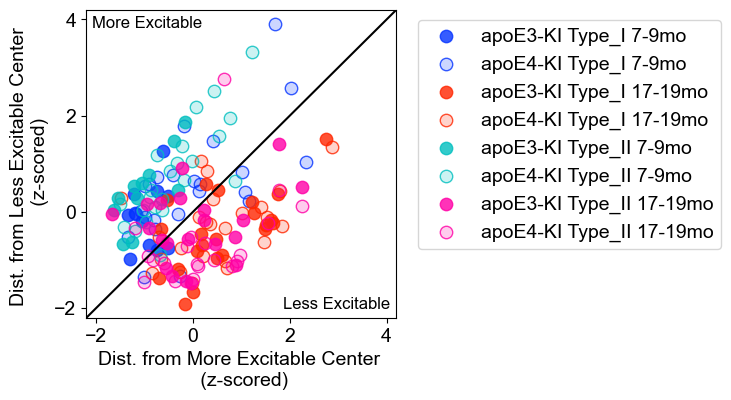

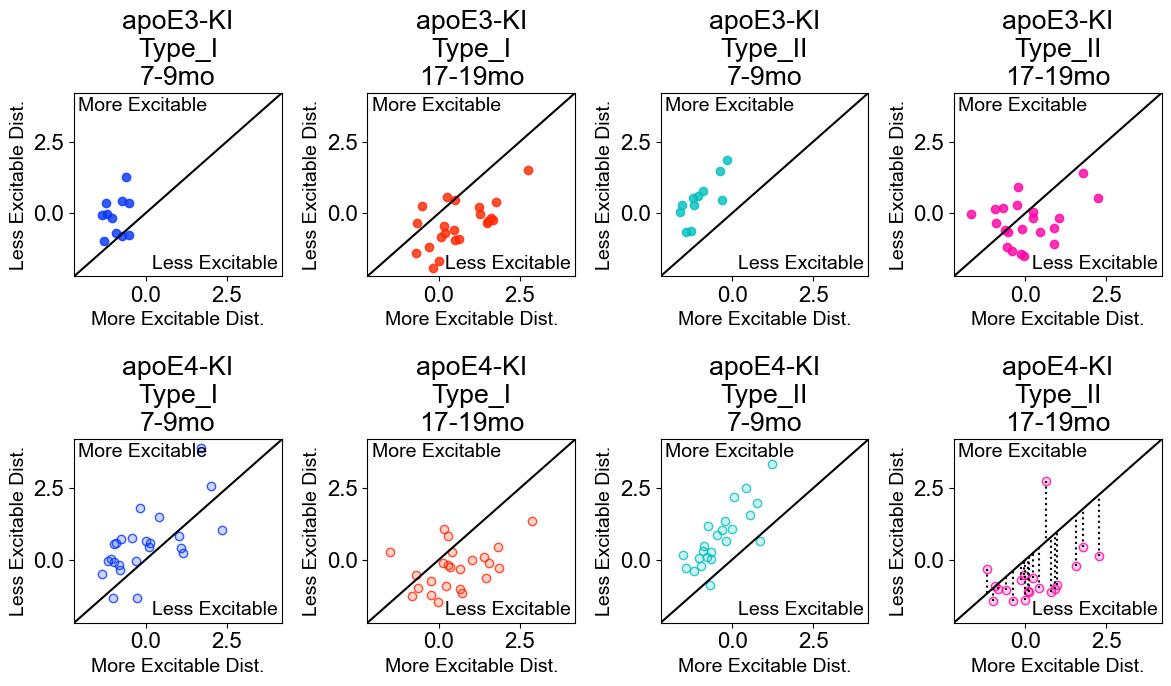

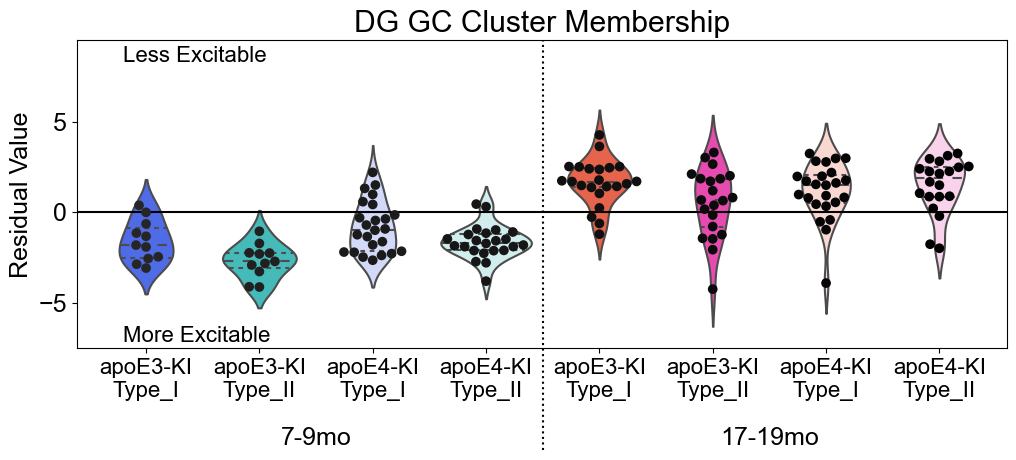

100%|██████████| 1000/1000 [00:21<00:00, 47.18it/s]
<ipython-input-51-32e329e998a7>:552: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pseudo_truth = scipy.stats.mode(full_label_stack,axis=0, nan_policy='omit')[0]


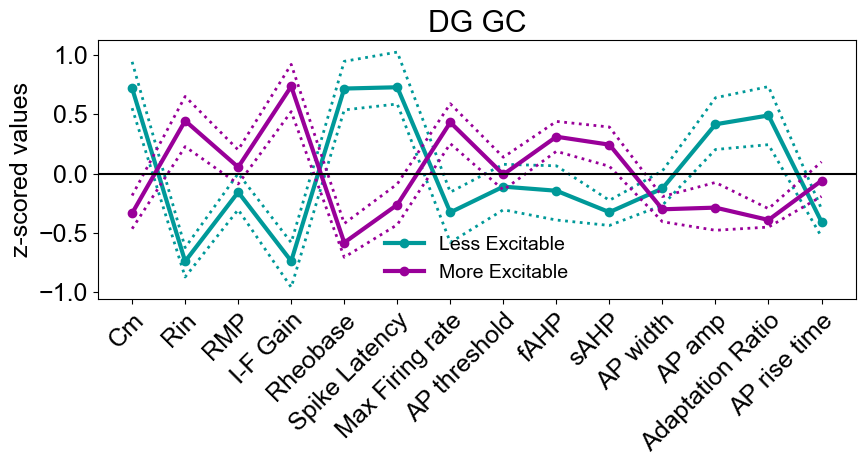

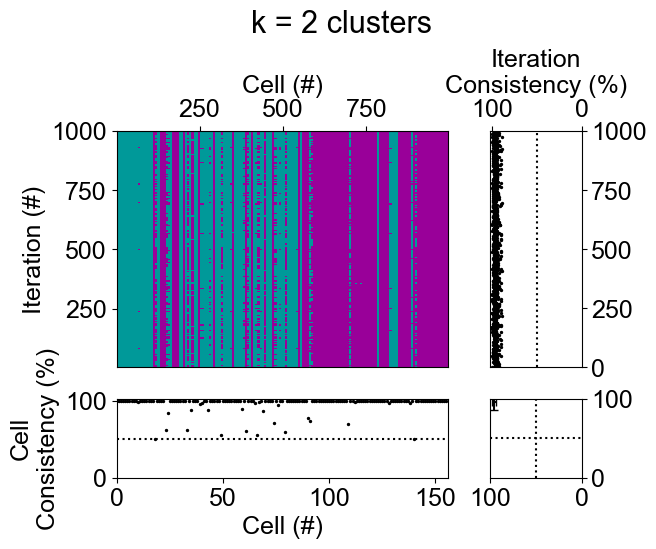

In [188]:
##### DG Combined ####
file_list_DG = [f for f in file_list if 'DG' in f]
print(file_list_DG)
dg_dict={}
for f in file_list_DG:
    f_dict,_=read_data_file(f)
    for k,v in f_dict.items():
        if 'II' in f: k=k.replace('KI','KI Type_II')
        if ' I ' in f: k=k.replace('KI','KI Type_I')
        dg_dict[k]=v

folder ='DG_Comb'
try: os.makedirs(folder)
except: None
full_df = dict_to_df(dg_dict,AP_cut=60)
labeling = ['cell','Cell','type','extra']
numericals, data_for_fit, full_df_no_null = clean_data(labeling, full_df)
type_num, num_t, uniq_types,type_list = get_types(full_df_no_null)

new_uniq = uniq_types
new_uniq = [t for t in new_uniq if '-9' in t] + [t for t in new_uniq if '-19' in t] 
new_uniq = [t for t in new_uniq if '_I ' in t] + [t for t in new_uniq if '_II ' in t] 
ord = [uniq_types.index(n) for n in new_uniq]
uniq_types = [uniq_types[o] for o in ord]
type_num = [ord[t] for t in type_num]
type_list = [uniq_types[t] for t in type_num]
counts = [np.sum( [tt==t for tt in type_list]) for t in uniq_types ]
plot_summary_DG_comb(num_t,numericals,type_list,uniq_types,anDGC_packaged,df_for_34_2W_anova,folder,fig_opt =fig_opt)

anDGC_packaged['k2_cval'] = k2_cval = cross_val(data_for_fit,numericals,False,folder,k=2,num_iter = 1000,SubSampleFrac = .8,
            cell_type=anDGC_packaged['cell_type'],fig_opt =fig_opt,ds_iter=5)


anDGC_packaged = cluster_full(data_for_fit,folder,numericals)
anDGC_packaged['cell_type']='DG GC'
df_for_34_2W_anova, tukey_data = do_stats(type_list,anDGC_packaged['score'])


_ = [print(t)for t in uniq_types]

plot_summary_DG_comb(num_t,numericals,type_list,uniq_types,anDGC_packaged,df_for_34_2W_anova,folder,fig_opt =fig_opt)
anDGC_packaged['k2_cval'] = k2_cval = cross_val(data_for_fit,numericals,False,folder,k=2,num_iter = 1000,SubSampleFrac = .8,
            cell_type=anDGC_packaged['cell_type'],fig_opt =fig_opt,ds_iter=5)
# _ = cross_val(data_for_fit,numericals,anDGC_packaged['new_cent_order'],folder,k=3,num_iter = 1000,SubSampleFrac = .8,
#             cell_type=anDGC_packaged['cell_type'],fig_opt =fig_opt,ds_iter=5)
# _ = cross_val(data_for_fit,numericals,anDGC_packaged['new_cent_order'],folder,k=4,num_iter = 1000,SubSampleFrac = .8,
#             cell_type=anDGC_packaged['cell_type'],fig_opt =fig_opt,ds_iter=5)
# _ = cross_val(data_for_fit,numericals,anDGC_packaged['new_cent_order'],folder,k=5,num_iter = 1000,SubSampleFrac = .8,
#             cell_type=anDGC_packaged['cell_type'],fig_opt =fig_opt,ds_iter=5)
# save_dl(folder)

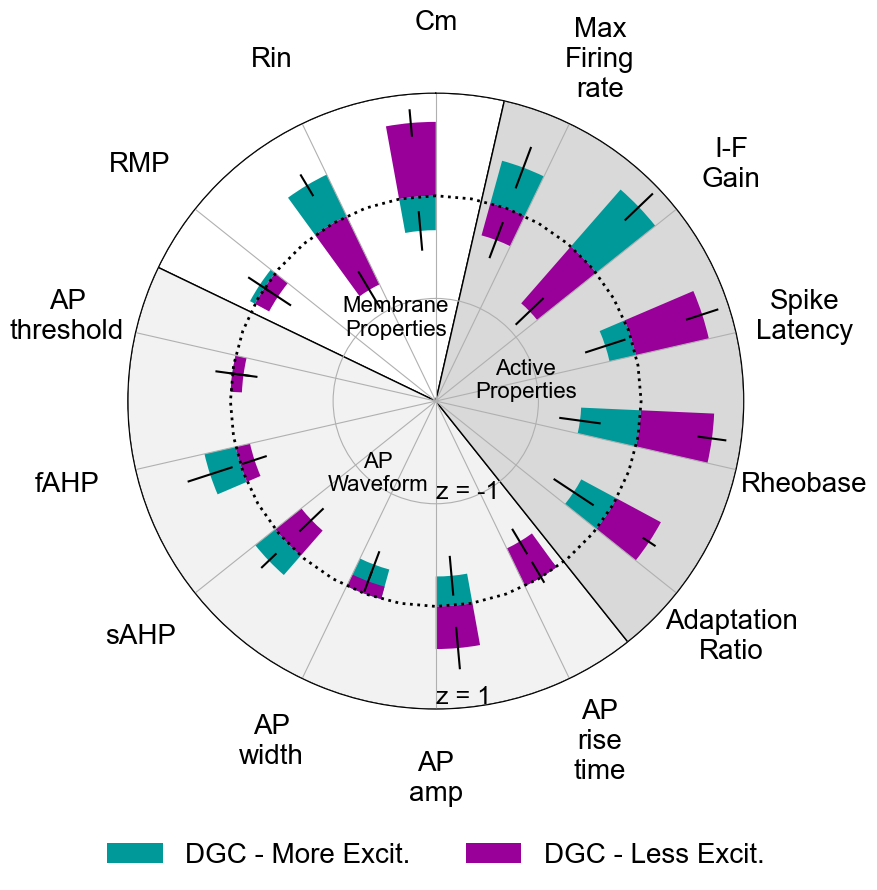

In [99]:
######### Combined DGC Centroids

feat_ord = ['Cm', 'Rin', 'RMP',  'AP threshold', 'fAHP', 'sAHP', 'AP width', 'AP amp', 'AP rise time', 'Adaptation Ratio', 'Rheobase', 'Spike Latency','I-F Gain', 'Max Firing rate']
f_order = [np.where(features==fi)[0][0] for fi in feat_ord]

alt_DG_centers, ax = plt.subplots(1,1,figsize=(16,8),subplot_kw={'projection': 'polar'})
rad_feats =features[f_order] # np.append(features[f_order],features[f_order[0]])
theta = (np.arange(len(features) ) / float(len(features))) * 2 * np.pi  
ax.set_theta_zero_location("N")
rad_feats=[f.replace(' ','\n') for f in rad_feats]
ax.set_xticks(theta[:],rad_feats[:],fontsize = 20,)
tiks = [-1,1] # -0.5,0,0.5, 
ax.set_ylim(bottom=-2, top=3)
ax.set_rlabel_position(180)
full_x = np.append(np.arange(0,360,10)/360*np.pi*2,0)


full_y_zero = np.zeros_like(full_x)
ax.plot(full_x,full_y_zero,':k',linewidth=2) # R=0 Line
ax.tick_params(pad=40)

centers = anDGC_packaged['k2_cval']['mean_center']

radii_m = centers[f_order,0]
radii_l = centers[f_order,1]

ax.set_yticks([-1,1]) # -0.5,0,0.5,
ax.set_ylim(bottom=-2, top=1)

m_label = 'DGC' + ' - More Excit.'
l_label = 'DGC' + ' - Less Excit.'

m_color = cmap[0,:]*[1,1,1,(ci+1)/num_types]
l_color = cmap[1,:]*[1,1,1,(ci+1)/num_types]
d_theta = theta[1]*0.8


m_error_H = anDGC_packaged['k2_cval']['confidence'][1][:,1][f_order]
m_error_L = anDGC_packaged['k2_cval']['confidence'][0][:,1][f_order]
m_error_c = (m_error_H-m_error_L)/2  + m_error_L
m_abs_err = np.abs(m_error_H-m_error_c)

l_error_H = anDGC_packaged['k2_cval']['confidence'][1][:,0][f_order]
l_error_L = anDGC_packaged['k2_cval']['confidence'][0][:,0][f_order]
l_error_c = (l_error_H-l_error_L)/2  + l_error_L
l_abs_err = np.abs(l_error_H-l_error_c)

'Bars'
X_vals = theta[:]+d_theta/1*(ci/num_types)-d_theta/2/num_types*(num_types-1)
ax.bar(X_vals, radii_m[:], yerr=m_abs_err, label=m_label, color=m_color, width=d_theta/num_types/1)# ,yerr=radii_m_CI
ax.bar(X_vals, radii_l[:], yerr=l_abs_err, label=l_label, color=l_color, width=d_theta/num_types/1)# ,yerr=radii_l_CI

handles, bar_labels = plt.gca().get_legend_handles_labels()
order = np.arange(8)
order = np.append(np.arange(num_types)*2,np.arange(num_types)*2+1)
ax.legend(ncol=2,fontsize = 20,loc='lower center',frameon=False,bbox_to_anchor=(0.5, -0.3)) # 

# ax.legend([handles[i] for i in order],[bar_labels[i] for i in order],ncol=2,fontsize = 20,loc='lower center',frameon=False,bbox_to_anchor=(0.5, -0.4)) ## ,bbox_to_anchor=(1, 0), loc='upper center'
d_theta = 2*np.pi/14



fontsize=16
ax.text( d_theta*(1.5-0.5), -1.1, 'Membrane\nProperties', va='center',ha='center',fontsize=fontsize)
ax.text( d_theta*(6-0.5), -1.1, 'AP\nWaveform', va='center',ha='center',fontsize=fontsize)
ax.text( d_theta*(11.5-0.5), -1.1, 'Active\nProperties', va='center',ha='center',fontsize=fontsize)

ax.bar( d_theta*(1.5-0.5), 3, width = d_theta*3,color=[1*1]*3,zorder=-4,bottom=-2,edgecolor='k')
ax.bar( d_theta*(6-0.5), 3, width = d_theta*6,color=[1*.95]*3,zorder=-4,bottom=-2,edgecolor='k')
ax.bar( d_theta*(11.5-0.5), 3, width = d_theta*5,color=[1*.85]*3,zorder=-4,bottom=-2,edgecolor='k')
ax.set_yticks(tiks,[f'z = {t}' for t in tiks],rotation=45)
plt.show()
# alt_DG_centers.savefig('alt_DG_centers.'+fig_opt['format'],**fig_opt)
# colab.files.download('alt_DG_centers.'+fig_opt['format'])

In [ ]:
def errors(x,high,low):
    for i in len(high):
        line()

['Cm', 'Rin', 'RMP', 'AP\nthreshold', 'fAHP', 'sAHP', 'AP\nwidth', 'AP\namp', 'AP\nrise\ntime', 'Adaptation\nRatio', 'Rheobase', 'Spike\nLatency', 'I-F\nGain', 'Max\nFiring\nrate']


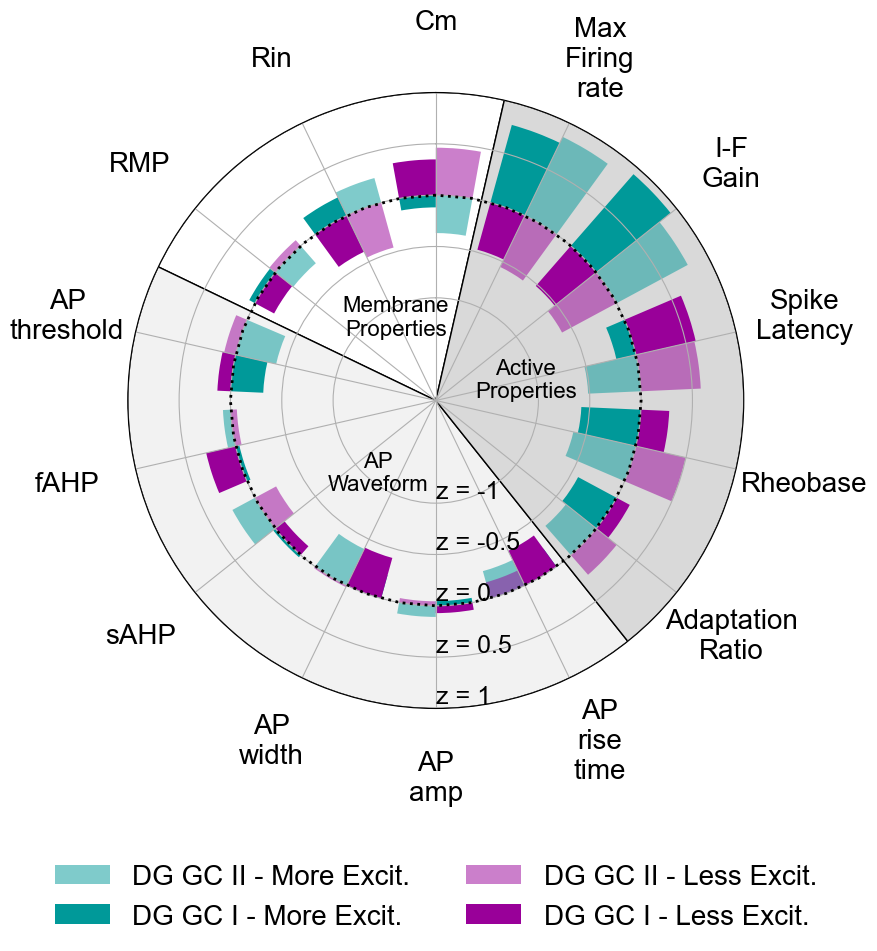

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# https://www.tutorialspoint.com/how-to-make-a-polygon-radar-spider-chart-in-python-matplotlib
# features =  np.array(multipack['CA3 PC']['features'])
feat_ord = ['Cm', 'Rin', 'RMP',  'AP threshold', 'fAHP', 'sAHP', 'AP width', 'AP amp', 'AP rise time', 'Adaptation Ratio', 'Rheobase', 'Spike Latency','I-F Gain', 'Max Firing rate']
f_order = [np.where(features==fi)[0][0] for fi in feat_ord]

alt_DG_centers, ax = plt.subplots(1,1,figsize=(16,8),subplot_kw={'projection': 'polar'})
rad_feats =features[f_order] # np.append(features[f_order],features[f_order[0]])
theta = (np.arange(len(features) ) / float(len(features))) * 2 * np.pi  
# theta = theta + np.pi/2
ax.set_theta_zero_location("N")
rad_feats=[f.replace(' ','\n') for f in rad_feats]
ax.set_xticks(theta[:],rad_feats[:],fontsize = 20,)
tiks = [-1,-0.5,0,0.5,1]
ax.set_ylim(bottom=-2, top=1)
ax.set_rlabel_position(180)
full_x = np.append(np.arange(0,360,10)/360*np.pi*2,0)

full_y_zero = np.zeros_like(full_x)
ax.plot(full_x,full_y_zero,':k',linewidth=2)
ax.tick_params(pad=40)

ci_types = [list(multipack.keys())[ci]   for ci in range(len(multipack))]
ci_types = [c for c in ci_types if 'DG' in c]
num_types = len(ci_types)
centers = [multipack[ci_type]['centers'] for ci_type in ci_types]
center_conc = np.concatenate(centers,axis=-1)
center_mins = np.min(center_conc,axis=1)

print(rad_feats)
for ci in range(num_types):
    ci_type = ci_types[ci]    
    centers = multipack[ci_type]['centers']
    # centers = (multipack[ci_type]['k2_cval']['mean_center'] )[ restore_order(multipack[ci_type]['new_cent_order']),:]
    # centers = centers
    # radii_m = np.append(centers[f_order,0],centers[f_order[0],0])
    # radii_l = np.append(centers[f_order,1],centers[f_order[0],1])

    

    radii_m = centers[f_order,0]
    radii_l = centers[f_order,1]

    CI = multipack[ci_type]['k2_cval']['confidence']
    # print(CI)
    radii_m_CI = CI[0][f_order,:]
    radii_l_CI = CI[1][f_order,:]
    # print(radii_m_CI)

    ax.set_yticks([-1,-0.5,0,0.5,1])
    ax.set_ylim(bottom=-2, top=1)

    m_label = ci_type + ' - More Excit.'
    l_label = ci_type + ' - Less Excit.'

    m_color = cmap[0,:]*[1,1,1,(ci+1)/num_types]
    l_color = cmap[1,:]*[1,1,1,(ci+1)/num_types]
    d_theta = theta[1]*0.8

    # 'Spider'
    # ax.plot(theta[:],radii_m[:],label=m_label,color=m_color,linewidth=3,marker='.',markersize=10)
    # ax.plot(theta[:],radii_l[:],label=l_label,color=l_color,linewidth=3,marker='.',markersize=10)

    # 'Steps'
    # ax.step(theta[:]-theta[1]/2,radii_m[:],label=m_label,color=m_color,linewidth=3)
    # ax.step(theta[:]-theta[1]/2,radii_l[:],label=l_label,color=l_color,linewidth=3)

    'Bars'
    radii_m_CI=np.abs(radii_m_CI.T - np.stack([radii_m,radii_m]))
    radii_l_CI=np.abs(radii_l_CI.T - np.stack([radii_l,radii_l]))

    ax.bar(theta[:]+d_theta/1*(ci/num_types)-d_theta/2/num_types*(num_types-1),radii_m[:],label=m_label,color=m_color,width=d_theta/num_types/1)# ,yerr=radii_m_CI
    ax.bar(theta[:]+d_theta/1*(ci/num_types)-d_theta/2/num_types*(num_types-1),radii_l[:],label=l_label,color=l_color,width=d_theta/num_types/1)# ,yerr=radii_l_CI

handles, bar_labels = plt.gca().get_legend_handles_labels()
order = np.arange(8)
order = np.append(np.arange(num_types)*2,np.arange(num_types)*2+1)
# ax.legend(ncol=2,fontsize = 20,loc='lower center',frameon=False,bbox_to_anchor=(0.5, -0.5)) # 

ax.legend([handles[i] for i in order],[bar_labels[i] for i in order],ncol=2,fontsize = 20,loc='lower center',frameon=False,bbox_to_anchor=(0.5, -0.4)) ## ,bbox_to_anchor=(1, 0), loc='upper center'
d_theta = 2*np.pi/14


fontsize=16
ax.text( d_theta*(1.5-0.5), -1.1, 'Membrane\nProperties', va='center',ha='center',fontsize=fontsize)
ax.text( d_theta*(6-0.5), -1.1, 'AP\nWaveform', va='center',ha='center',fontsize=fontsize)
ax.text( d_theta*(11.5-0.5), -1.1, 'Active\nProperties', va='center',ha='center',fontsize=fontsize)

ax.bar( d_theta*(1.5-0.5), 3, width = d_theta*3,color=[1*1]*3,zorder=-4,bottom=-2,edgecolor='k')
ax.bar( d_theta*(6-0.5), 3, width = d_theta*6,color=[1*.95]*3,zorder=-4,bottom=-2,edgecolor='k')
ax.bar( d_theta*(11.5-0.5), 3, width = d_theta*5,color=[1*.85]*3,zorder=-4,bottom=-2,edgecolor='k')
ax.set_yticks(tiks,[f'z = {t}' for t in tiks],rotation=45)
plt.show()
alt_DG_centers.savefig('alt_DG_centers.'+fig_opt['format'],**fig_opt)
colab.files.download('alt_DG_centers.'+fig_opt['format'])



In [6]:
### DG Only Layout
label_size = 32
row_0 =25
row_1 =row_0+330
row_2 =row_1+700
row_3 = row_2+300
width = 1800
length = 2200


scale = 1
dg_layout_1 = Figure(str(width), str(length),
                    Panel(SVG("/content/DG_Comb/Normalized_Vals_split.svg").scale(scale*1),
                    Text("A", 0, 20, size=label_size)
                    ).move(width*0, row_0),
                    
                    Panel(SVG("/content/DG_Comb/GenoType_dist_Separate.svg").scale(scale*1.3),
                    Text("B", 0, 20, size=label_size)
                    ).move(width*0, row_1),
                     
                    Panel(SVG("/content/DG_Comb/fig_violin_residuals.svg").scale(scale*.75),
                    Text("C", 0, 20, size=label_size)
                    ).move(width*0, row_2),    
                     
                    Panel(SVG("/content/DG_Type_I_GC_main_parameters_Clean/fig_violin_residuals.svg").scale(scale*.75),
                    Text("D", 0, 20, size=label_size)
                    ).move(width*0, row_3),
                    Panel(SVG("/content/DG_Type_II_GC_main_parameters_Clean/fig_violin_residuals.svg").scale(scale*.75),
                    Text("E", 0, 20, size=label_size)
                    ).move(width*0.185, row_3),    

                    Panel(SVG("/content/alt_DG_centers.svg").scale(scale*.85),
                    Text("F", 0, 20, size=label_size)
                    ).move(width*0.35, row_2),    

            )
# dg_layout_1.save("dg_layout_1.svg")
# display(dg_layout_1)
# colab.files.download('dg_layout_1.svg')




row_2 =20
row_3 = row_2+300
width = 1800

scale = 1
dg_layout_2 = Figure(str(width), str(length),
                    # Panel(SVG("/content/DG_Comb/Normalized_Vals_split.svg").scale(scale*1),
                    # Text("A", 0, 20, size=label_size)
                    # ).move(width*0, row_0),
                    
                    # Panel(SVG("/content/DG_Comb/GenoType_dist_Separate.svg").scale(scale*1.3),
                    # Text("B", 0, 20, size=label_size)
                    # ).move(width*0, row_1),
                     
                    Panel(SVG("/content/DG_Comb/fig_violin_residuals.svg").scale(scale*.75),
                    Text("A", 0, 20, size=label_size)
                    ).move(width*0, row_2),    
                     
                    Panel(SVG("/content/DG_Type_I_GC_main_parameters_Clean/fig_violin_residuals.svg").scale(scale*.75),
                    Text("B", 0, 20, size=label_size)
                    ).move(width*0, row_3),
                    Panel(SVG("/content/DG_Type_II_GC_main_parameters_Clean/fig_violin_residuals.svg").scale(scale*.75),
                    Text("C", 0, 20, size=label_size)
                    ).move(width*0.185, row_3),    

                    Panel(SVG("/content/alt_DG_centers.svg").scale(scale*.80),
                    Text("D", 0, 20, size=label_size)
                    ).move(width*0.35, row_2),    

            )
dg_layout_2.save("dg_layout_2.svg")
display(dg_layout_2)
colab.files.download('dg_layout_2.svg')




NameError: ignored

In [ ]:
multipack[ci_type].keys()